Shifted cementing file written to: Data/XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 2 - Vlieland Claystone_Cementing Unit_Data_shifted_minus1h2m.txt


/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_56749/1613371946.py:207: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  full_index = pd.date_range(startD, endD, freq="1S")


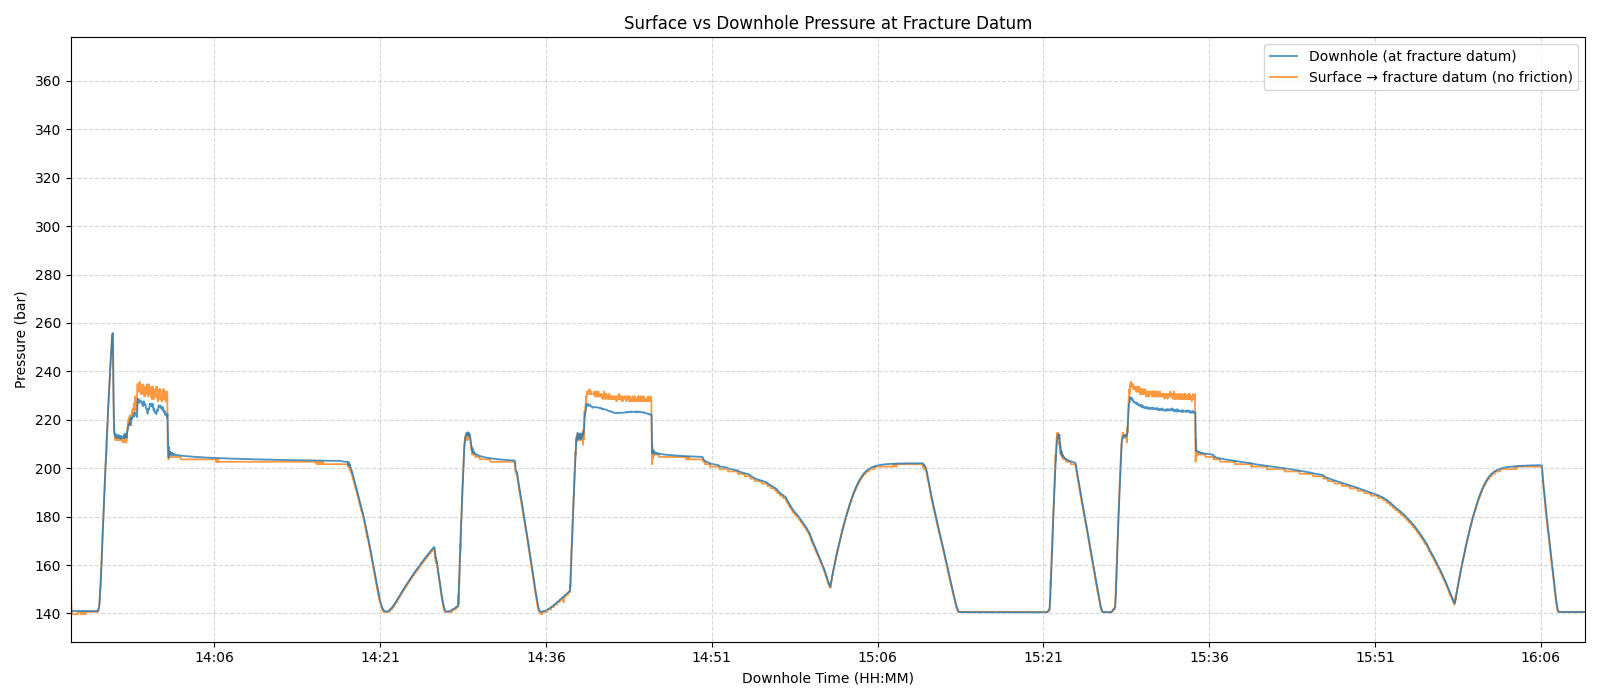

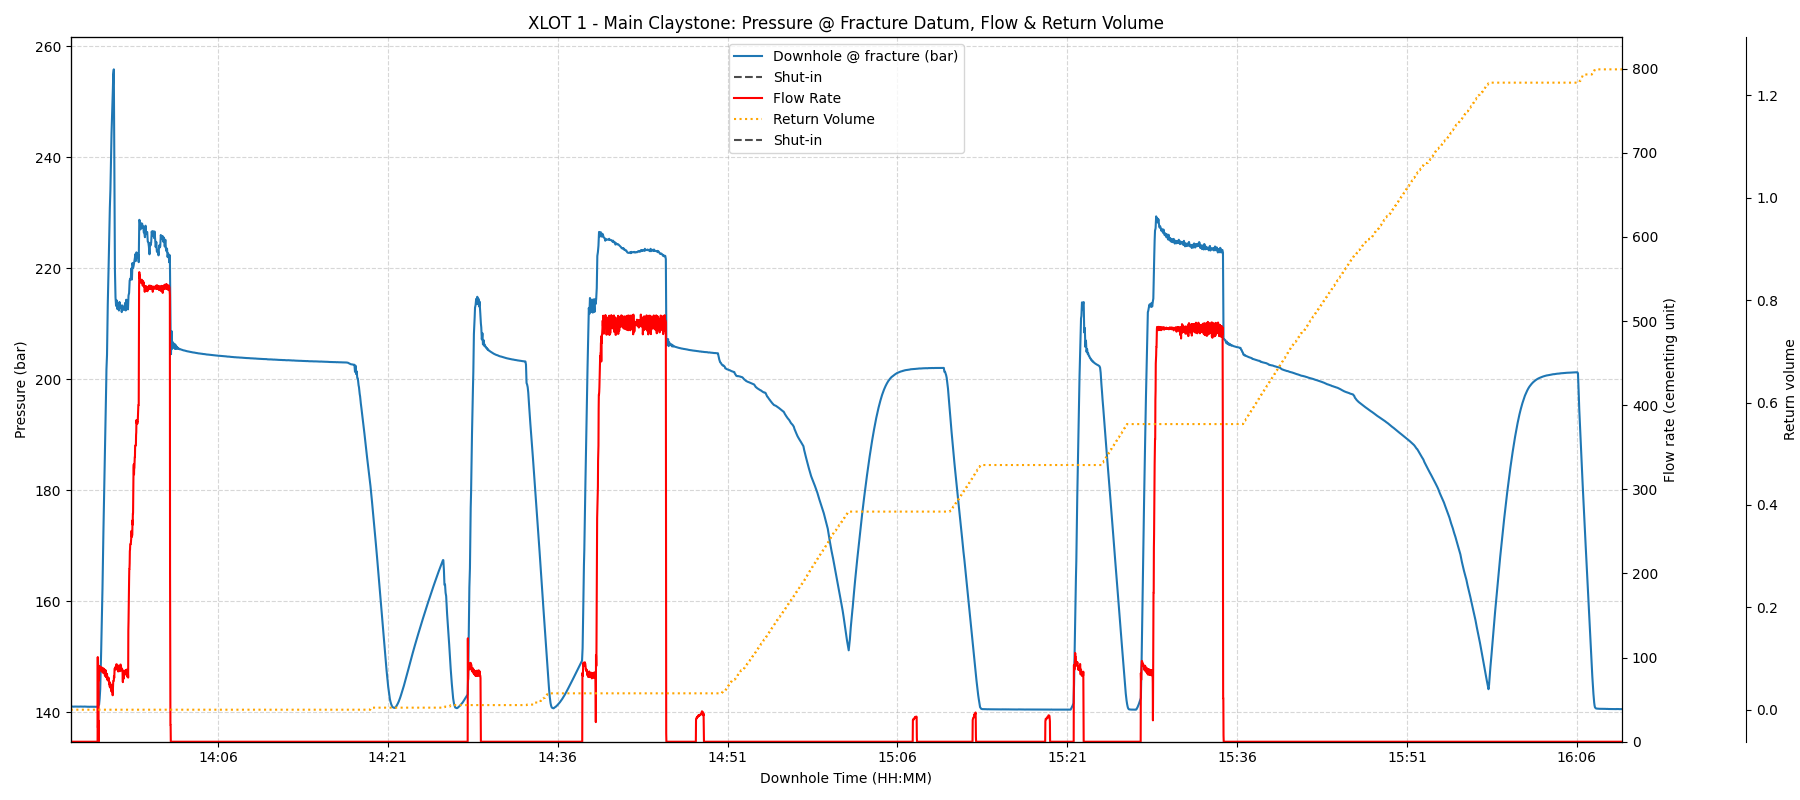

In [62]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import re
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

from FCP_classes_2 import (
    HaimsonBilinearPicker,
    system_stiffness_pick,
    castillo_analyze_cycle_df,
    barree_pick,
)

from old_code import time_difference
from old_code import well_corrections

%matplotlib widget

# ------------------------------ Config ------------------------------
base = Path("Data")

DOWNHOLE_FILE = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 2 - Vlieland Claystone_Downhole Gauge_Data.TXT"
CEMENT_FILE   = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 2 - Vlieland Claystone_Cementing Unit_Data.txt"
SHIFT_HOURS   = 0.9963
OUT_SUFFIX    = "_shifted_minus1h2m"  # appended before extension

# Time window (downhole clock)
startD = pd.to_datetime("2023-12-12 13:53:00")
endD   = pd.to_datetime("2023-12-12 16:10:00")

# Set shut-in times after visual inspection
USE_MANUAL_SHUTIN      = True
MANUAL_SHUTINS_DH = [
    # You can pass either floats in hours since startD (e.g., 0.75)
    # or absolute timestamps as strings. Example:
    # "2023-12-10 15:00:00",
    pd.Timestamp("2023-12-11 14:23:45"),
    pd.Timestamp("2023-12-11 15:45:30"),
    pd.Timestamp("2023-12-11 16:13:48")
]

# Hydrostatic correction to FRACTURE datum (Config)

# (A) Geometry / sensor positions (replace with your true arrays if needed)
MD = np.array([900.2, 910, 919.6], dtype=float)
TVD = np.array([900.18, np.nan, 919.58], dtype=float)  # NaN = missing value
TVD_fracture_m = 1323.25
gauge_index    = 1
TVD_surface_sensor_m = -1.46   # surface transducer above TVD=0 by 1.46 m

# (B) Use helper to get positions and ΔTVDs (down-positive)
TVD_interp, TVD_gauge_m, delta_tvd_gauge_to_frac_m = well_corrections.estimate_lag(
    MD, TVD, gauge_index, TVD_fracture_m
)
delta_tvd_surface_to_frac_m = TVD_fracture_m - TVD_surface_sensor_m

# (C) Unit constants
PSIA_TO_BAR = 1.0 / 14.5037738
RHO = 1075     # kg/m^3  <-- set this to your actual fluid density
G   = 9.80665    # m/s^2
PA_TO_BAR = 1e-5



# ------------------------------ Utilities ------------------------------
_ts_pat = re.compile(r"^\d{2}:\d{2}:\d{4}:\d{2}:\d{2}:\d{2}$")

def to_float_smart(s):
    if s is None:
        return None
    txt = str(s).strip().replace("\u00A0", " ").replace(",", ".")
    tokens = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", txt)
    if not tokens:
        return None
    for tok in tokens:
        if "." in tok:
            try:
                return float(tok)
            except ValueError:
                continue
    try:
        return float(tokens[0])
    except ValueError:
        return None

def shift_cement_file_time(fp_in: Path, hours_earlier: float) -> Path:
    shift = timedelta(hours=hours_earlier)
    fp_out = fp_in.with_name(fp_in.stem + OUT_SUFFIX + fp_in.suffix)
    with open(fp_in, "r", encoding="utf-8", errors="ignore") as fin, \
         open(fp_out, "w", encoding="utf-8", errors="ignore") as fout:
        for line in fin:
            raw = line.rstrip("\n")
            parts = raw.split("\t")
            if parts and _ts_pat.fullmatch(parts[0].strip()):
                try:
                    dt = datetime.strptime(parts[0].strip(), "%m:%d:%Y:%H:%M:%S")
                    new_dt = dt - shift
                    parts[0] = new_dt.strftime("%m:%d:%Y:%H:%M:%S")
                    fout.write("\t".join(parts) + "\n")
                except Exception:
                    fout.write(line)
            else:
                fout.write(line)
    return fp_out

# ------------------------------ Parsers ------------------------------
def parse_downhole(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            ln = ln.strip()
            # allow leading integer point number, then date, time, delta, pressure, temp
            m = re.match(
                r"\d+\s+(\d{2}-\d{2}-\d{4})\s+"
                r"(\d{2}:\d{2}:\d{2})\s+"
                r"([+-]?\d[\d,\.]*)\s+"
                r"([+-]?\d[\d,\.]*)\s+"
                r"([+-]?\d[\d,\.]*)",
                ln,
            )
            if not m:
                continue

            date_s, time_s, delta_s, p_s, t_s = m.groups()

            def to_float_basic(s: str):
                s = s.replace(" ", "").replace(",", ".")
                try:
                    return float(s)
                except ValueError:
                    return None

            rows.append({
                "timestamp": f"{date_s} {time_s}",
                "delta": to_float_basic(delta_s),
                "pressure": to_float_basic(p_s),
                "temp": to_float_basic(t_s),
            })

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Downhole: no data recognized.")

    df["time"] = pd.to_datetime(
        df["timestamp"],
        format="%d-%m-%Y %H:%M:%S",
        errors="coerce",
    )
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["pressure", "delta", "temp"]]

def parse_cementing_with_return_volume(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            parts = ln.strip().split("\t")
            if not parts:
                continue
            t = parts[0].strip()
            if not _ts_pat.fullmatch(t):
                continue
            MM, dd, yyyy, HH, MM2, SS = t.split(":")
            ts_str = f"{dd}-{MM}-{yyyy} {HH}:{MM2}:{SS}"
            treating_pressure = to_float_smart(parts[1]) if len(parts) > 1 else None
            flow_rate        = to_float_smart(parts[2]) if len(parts) > 2 else None
            volume           = to_float_smart(parts[4]) if len(parts) > 4 else None   # <— pumped volume (normal)
            return_volume    = to_float_smart(parts[8]) if len(parts) > 8 else None

            rows.append({
                "timestamp": ts_str,
                "treating_pressure": treating_pressure,
                "flow_rate": flow_rate,
                "volume": volume,                  # <—
                "return_volume": return_volume,
            })
    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("Cementing: no data recognized.")
    df["time"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S", dayfirst=True, errors="coerce")
    df = df.dropna(subset=["time"]).set_index("time").sort_index()
    return df[["flow_rate", "treating_pressure", "volume", "return_volume"]]



# 1) Write shifted cementing file (timestamps shifted earlier)
shifted_fp = shift_cement_file_time(CEMENT_FILE, SHIFT_HOURS)
print(f"Shifted cementing file written to: {shifted_fp}")

# 2) Load downhole + shifted cementing
dh_df = parse_downhole(DOWNHOLE_FILE)
cm_df = parse_cementing_with_return_volume(shifted_fp)

# --- NEW: hard-crop BOTH datasets to the downhole window ---
dh_df = dh_df.loc[startD:endD]
cm_df = cm_df.loc[startD:endD]

# De-duplicate cementing timestamps (before interpolation)
cm_df = cm_df.groupby(cm_df.index).mean(numeric_only=True)

# --- NEW: build the exact 1-second grid from the window ---
full_index = pd.date_range(startD, endD, freq="1S")

# Interpolate each dataset directly onto the window grid
dh_full = dh_df.reindex(full_index).interpolate("time")
cm_full = cm_df.reindex(full_index).interpolate("time")

# Combine (only the columns you need)
combined = pd.concat(
    [dh_full[["pressure"]],
     cm_full[["flow_rate", "treating_pressure", "volume", "return_volume"]]],
    axis=1
)

# ---- X axis as elapsed hours from startD (i.e., 0 at startD) ----
hours = (combined.index - combined.index[0]) / pd.Timedelta(hours=1)
total_hours = (endD - startD) / pd.Timedelta(hours=1)

# ----------------------------
# Hydrostatic correction to FRACTURE datum
# ----------------------------

# (A) Convert both pressure series to bar
combined["pressure_bar"]          = combined["pressure"] * PSIA_TO_BAR
combined["treating_pressure_bar"] = combined["treating_pressure"] 

# (B) Hydrostatic head to translate to fracture datum (ignore friction for now)
dP_gauge_to_frac_bar = (RHO * G * delta_tvd_gauge_to_frac_m)  * PA_TO_BAR
dP_surf_to_frac_bar  = (RHO * G * delta_tvd_surface_to_frac_m) * PA_TO_BAR

# Downhole gauge -> fracture datum (add head if fracture deeper)
combined["P_dh_at_frac_bar"]   = combined["pressure_bar"] + dP_gauge_to_frac_bar
# Surface treating -> fracture datum (no friction term)
combined["P_surf_at_frac_bar"] = combined["treating_pressure_bar"] + dP_surf_to_frac_bar

# ----------------------------
# Plot 1
# ----------------------------
fig, ax = plt.subplots(figsize=(16, 7))

p_dh_frac   = combined["P_dh_at_frac_bar"]
p_surf_frac = combined["P_surf_at_frac_bar"]
mask1 = p_dh_frac.notna()
mask2 = p_surf_frac.notna()

# --- NEW: plot against real timestamps (downhole clock) ---
ax.plot(combined.index[mask1], p_dh_frac[mask1],
        label="Downhole (at fracture datum)", linewidth=1.3, zorder=1, alpha=0.8)

ax.plot(combined.index[mask2], p_surf_frac[mask2],
        label="Surface → fracture datum (no friction)", linewidth=1.3, zorder=0, alpha=0.8)

ax.set_xlabel("Downhole Time (HH:MM)")
ax.set_ylabel("Pressure (bar)")
ax.set_title("Surface vs Downhole Pressure at Fracture Datum")

# --- NEW: format ticks as HH:MM ---
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))  # adjust freely

ax.yaxis.set_major_locator(mticker.MultipleLocator(20))
ax.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)

# --- NEW: use real timestamps instead of hour floats ---
ax.set_xlim(startD, endD)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ----------------------------
# Plot 2
# ----------------------------

fig, ax1 = plt.subplots(figsize=(18, 8))

# --- plot against timestamps ---
ax1.plot(combined.index, combined["P_dh_at_frac_bar"],
         label="Downhole @ fracture (bar)")

ax1.set_xlabel("Downhole Time (HH:MM)")
ax1.set_ylabel("Pressure (bar)")

# --- format as HH:MM ---
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))

ax1.yaxis.set_major_locator(mticker.MultipleLocator(20))
ax1.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)

# twin axes use the same x-axis automatically
ax2 = ax1.twinx()
ax2.plot(combined.index, combined["flow_rate"], label="Flow Rate", color='red')
ax2.set_ylabel("Flow rate (cementing unit)")
ax2.set_ylim(0, 1.5 * np.nanmax(combined["flow_rate"]))

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.08))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.plot(combined.index, combined["return_volume"],
         label="Return Volume", linestyle=":", color="orange")
ax3.set_ylabel("Return volume")


# --- shut-in vertical lines (timestamps now) ---
shutin_line = None
if USE_MANUAL_SHUTIN and MANUAL_SHUTINS_DH:
    first_label_added = False
    for ts in MANUAL_SHUTINS_DH:
        try:
            shut_dt = pd.to_datetime(ts)
            ln = ax1.axvline(shut_dt, color="k", linestyle="--", alpha=0.7,
                             label="Shut-in" if not first_label_added else None)
            if not first_label_added:
                shutin_line = ln
                first_label_added = True
        except Exception as e:
            print(f"Warning parsing shut-in: {e}")


# --- NEW: x-limits use timestamps ---
ax1.set_xlim(startD, endD)

# Combine legends
lines, labels = [], []
for a in (ax1, ax2, ax3):
    ln, lb = a.get_legend_handles_labels()
    lines.extend(ln); labels.extend(lb)
if shutin_line is not None:
    lines.append(shutin_line); labels.append("Shut-in")

ax1.legend(lines, labels, loc="upper center")
plt.title("XLOT 1 - Main Claystone: Pressure @ Fracture Datum, Flow & Return Volume")
plt.tight_layout()
plt.show()



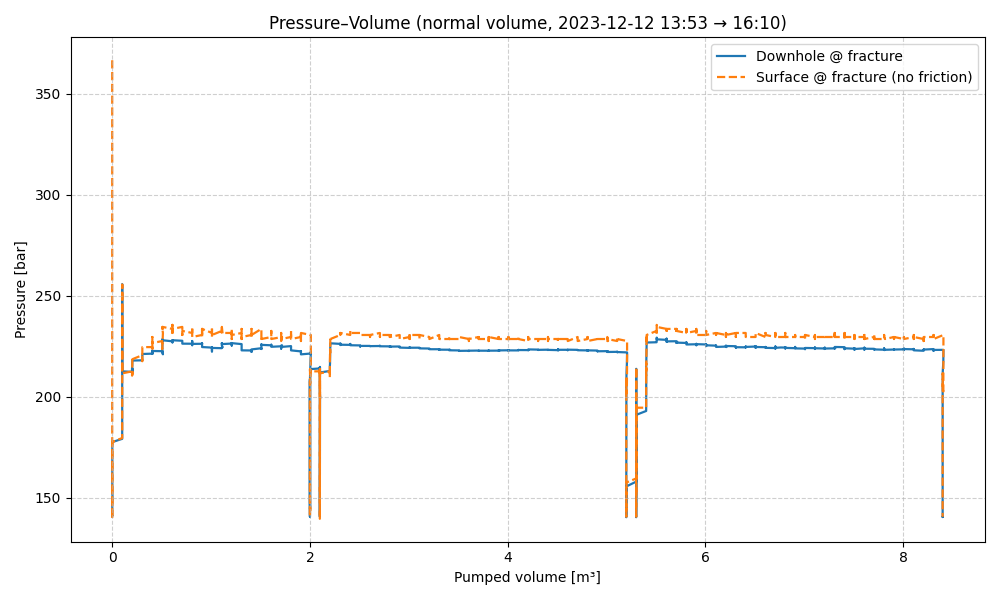

In [63]:
# ----------------------------
# Pressure vs Normal Volume (entire startD → endD window)
# ----------------------------
mask_window = (hours >= 0) & (hours <= total_hours)

V    = combined.loc[mask_window, "volume"]
P_dh = combined.loc[mask_window, "P_dh_at_frac_bar"]
P_sf = combined.loc[mask_window, "P_surf_at_frac_bar"]

df_pv = pd.DataFrame({"V": V, "P_dh": P_dh, "P_sf": P_sf}).dropna()

figPV, axPV = plt.subplots(figsize=(10, 6))
axPV.plot(df_pv["V"], df_pv["P_dh"], label="Downhole @ fracture", lw=1.6, zorder = 0)
axPV.plot(df_pv["V"], df_pv["P_sf"], label="Surface @ fracture (no friction)", lw=1.6, linestyle="--", zorder = 1)

axPV.set_xlabel("Pumped volume [m³]")
axPV.set_ylabel("Pressure [bar]")
axPV.set_title(f"Pressure–Volume (normal volume, {startD:%Y-%m-%d %H:%M} → {endD:%H:%M})")
axPV.grid(True, which="both", linestyle="--", alpha=0.6)
axPV.legend(loc="best")

plt.tight_layout()
plt.show()

Detected 4 cycles.


,start_idx,end_idx,t_start,t_end,duration,start_value,end_value,samples
0,178,1854,2023-12-12 13:17:58,2023-12-12 13:45:54,0 days 00:27:56,0.0,0.0,1677
1,2210,2217,2023-12-12 13:51:50,2023-12-12 13:51:57,0 days 00:00:07,0.0,0.0,8
2,2422,2425,2023-12-12 13:55:22,2023-12-12 13:55:25,0 days 00:00:03,0.0,0.0,4
3,2427,10528,2023-12-12 13:55:27,2023-12-12 16:10:28,0 days 02:15:01,0.0,0.0,8102


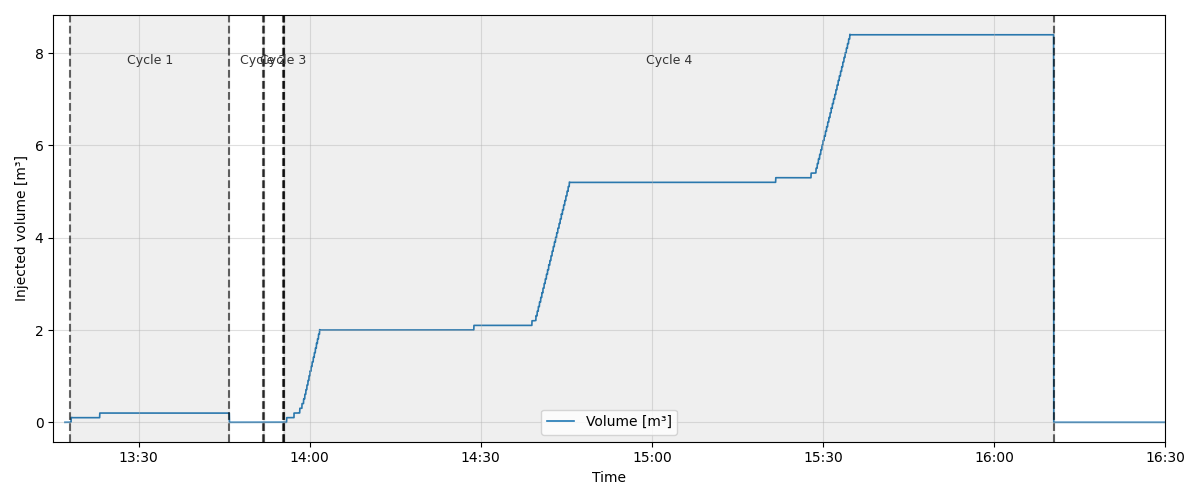

In [38]:
def detect_volume_cycles(volume,
                         tol=1e-3,
                         include_last_partial=True,
                         skip_all_zero_leading=True,
                         start_at=None,
                         end_at=None):
    """
    Detect pumping cycles from a 'normal' volume signal within a fixed window.

    - Crops to [start_at, end_at] if provided.
    - Cycle starts at the last near-zero sample before volume rises.
    - Cycle ends at the first near-zero sample after pumping stops.
    - If no trailing zero and include_last_partial=True, the cycle ends
      at the last *valid* (non-NaN) sample inside the window.
    - Optionally skip a leading all-zero “cycle”.
    """
    v = pd.Series(volume, copy=False).astype(float)

    # ---- Window crop -------------------------------------------------
    if start_at is not None:
        start_at = pd.to_datetime(start_at)
        v = v.loc[v.index >= start_at]
    if end_at is not None:
        end_at = pd.to_datetime(end_at)
        v = v.loc[v.index <= end_at]

    idx = v.index
    if len(v) == 0:
        return pd.DataFrame(columns=[
            "start_idx","end_idx","t_start","t_end","duration",
            "start_value","end_value","samples"
        ])

    # ---- Valid range & last valid -----------------------------------
    notna = v.notna().values
    if not notna.any():
        return pd.DataFrame(columns=[
            "start_idx","end_idx","t_start","t_end","duration",
            "start_value","end_value","samples"
        ])
    last_valid_idx = int(np.flatnonzero(notna)[-1])

    # ---- Zero/nonzero classification (NaNs are treated as non-zero/pumping neither) ---
    is_zero = (v.fillna(np.inf) < tol)

    # Transitions: zero→nonzero (start), nonzero→zero (end)
    start_boundary = is_zero.shift(1, fill_value=False) & (~is_zero)
    end_boundary   = (~is_zero.shift(1, fill_value=False)) & (is_zero)

    start_idx = np.flatnonzero(start_boundary.values)
    end_idx   = np.flatnonzero(end_boundary.values)

    cycles, s_ptr, e_ptr = [], 0, 0
    while s_ptr < len(start_idx):
        s_i = start_idx[s_ptr]
        t_start_i = max(0, s_i - 1)  # last zero before rise

        # move end pointer to first end strictly after start
        while e_ptr < len(end_idx) and end_idx[e_ptr] <= t_start_i:
            e_ptr += 1

        if e_ptr < len(end_idx):
            t_end_i = end_idx[e_ptr]
            e_ptr += 1
        else:
            # no trailing zero → end at last valid in-window if allowed
            if include_last_partial:
                t_end_i = last_valid_idx
            else:
                break

        # clip to last valid index within window
        t_end_i = min(t_end_i, last_valid_idx)

        if t_end_i > t_start_i:
            cycles.append((t_start_i, t_end_i))

        # advance to the next start after this end
        while s_ptr < len(start_idx) and start_idx[s_ptr] <= t_end_i:
            s_ptr += 1

    # Drop a leading all-zero segment if requested
    if skip_all_zero_leading and cycles:
        s0, e0 = cycles[0]
        if np.nanmax(v.iloc[s0:e0+1].values) < tol:
            cycles = cycles[1:]

    # Build DataFrame
    rows = []
    for s_i, e_i in cycles:
        t_start = idx[s_i]
        t_end   = idx[e_i]
        duration = (pd.to_datetime(t_end) - pd.to_datetime(t_start)
                    if isinstance(idx, pd.DatetimeIndex) else float(e_i - s_i))
        rows.append({
            "start_idx": int(s_i),
            "end_idx":   int(e_i),
            "t_start":   t_start,
            "t_end":     t_end,
            "duration":  duration,
            "start_value": float(v.iloc[s_i]),
            "end_value":   float(v.iloc[e_i]),
            "samples":   int(e_i - s_i + 1),
        })
    return pd.DataFrame(rows)

# ===== Use the global window you defined earlier =====
cycles_df = detect_volume_cycles(
    combined["volume"],
    tol=1e-3,
    include_last_partial=True,
    skip_all_zero_leading=True,
    start_at=startD,
    end_at=endD
)
print(f"Detected {len(cycles_df)} cycles.")
display(cycles_df)

# ===== Visual check with labeled regions (plot the same window) =====
work = combined.loc[startD:endD]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(work.index, work["volume"], label="Volume [m³]", lw=1.2, zorder = 1)

for i, cyc in enumerate(cycles_df.itertuples(index=False), start=1):
    ax.axvline(cyc.t_start, color="k", ls="--", alpha=0.6)
    ax.axvline(cyc.t_end,   color="k", ls="--", alpha=0.6)
    ax.axvspan(cyc.t_start, cyc.t_end, color="grey", alpha=0.12)
    y_top = np.nanmax(work["volume"].values)
    t_mid = pd.to_datetime(cyc.t_start) + (pd.to_datetime(cyc.t_end) - pd.to_datetime(cyc.t_start))/2
    ax.text(t_mid, 0.95*y_top if np.isfinite(y_top) else 0.0,
            f"Cycle {i}", ha="center", va="top", fontsize=9, color="0.2")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlim(startD, endD)
ax.set_ylabel("Injected volume [m³]")
ax.set_xlabel("Time")
ax.legend()
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

Detected 4 cycles from volume zeros in window 2023-12-12 13:15:00 → 2023-12-12 16:30:00.


,start_idx,end_idx,t_start,t_end,duration,start_value,end_value,samples
0,178,1854,2023-12-12 13:17:58,2023-12-12 13:45:54,0 days 00:27:56,0.0,0.0,1677
1,2210,2217,2023-12-12 13:51:50,2023-12-12 13:51:57,0 days 00:00:07,0.0,0.0,8
2,2422,2425,2023-12-12 13:55:22,2023-12-12 13:55:25,0 days 00:00:03,0.0,0.0,4
3,2427,10528,2023-12-12 13:55:27,2023-12-12 16:10:28,0 days 02:15:01,0.0,0.0,8102


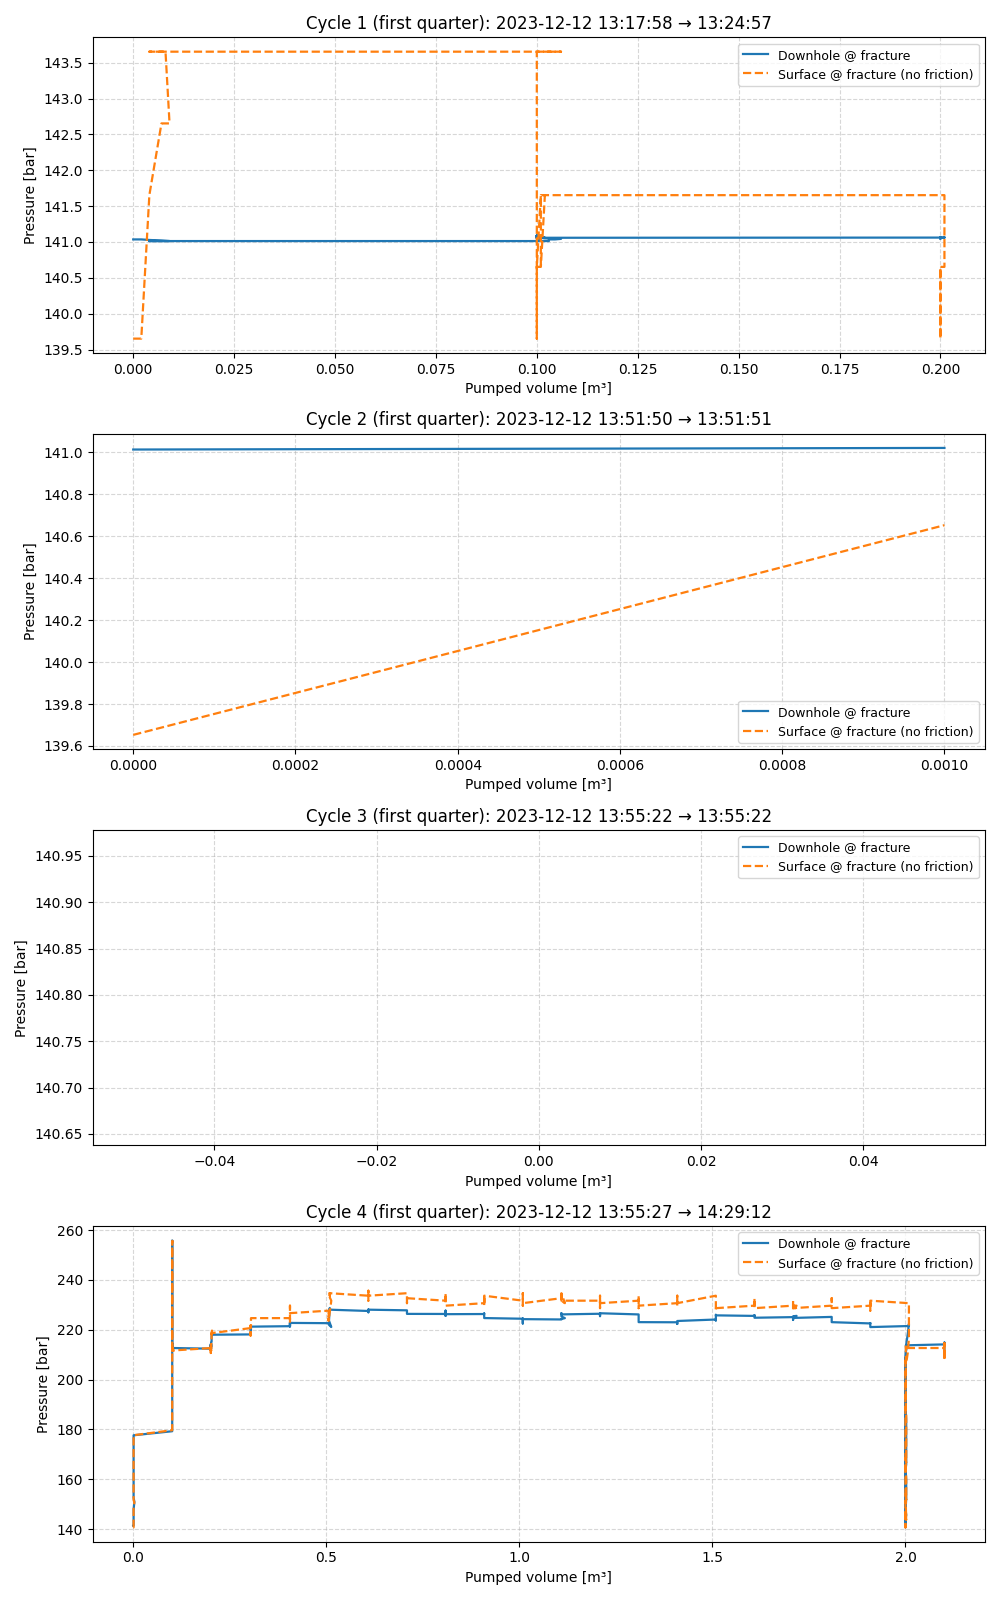

In [39]:
# ============================
# Plot Pressure vs Volume for each detected cycle (FIRST QUARTER by time)
# ============================


def detect_volume_cycles(volume,
                         tol=1e-3,
                         include_last_partial=True,
                         skip_all_zero_leading=True,
                         start_at=None,
                         end_at=None):
    v = pd.Series(volume, copy=False).astype(float)

    if start_at is not None:
        start_at = pd.to_datetime(start_at)
        v = v.loc[v.index >= start_at]
    if end_at is not None:
        end_at = pd.to_datetime(end_at)
        v = v.loc[v.index <= end_at]

    idx = v.index
    if len(v) == 0 or not v.notna().any():
        return pd.DataFrame(columns=["start_idx","end_idx","t_start","t_end","duration",
                                     "start_value","end_value","samples"])

    last_valid_idx = int(np.flatnonzero(v.notna().values)[-1])
    is_zero = (v.fillna(np.inf) < tol)
    start_boundary = is_zero.shift(1, fill_value=False) & (~is_zero)
    end_boundary   = (~is_zero.shift(1, fill_value=False)) & (is_zero)

    start_idx = np.flatnonzero(start_boundary.values)
    end_idx   = np.flatnonzero(end_boundary.values)

    cycles, s_ptr, e_ptr = [], 0, 0
    while s_ptr < len(start_idx):
        s_i = start_idx[s_ptr]
        t_start_i = max(0, s_i - 1)
        while e_ptr < len(end_idx) and end_idx[e_ptr] <= t_start_i:
            e_ptr += 1
        if e_ptr < len(end_idx):
            t_end_i = end_idx[e_ptr]
            e_ptr += 1
        else:
            if include_last_partial:
                t_end_i = last_valid_idx
            else:
                break
        t_end_i = min(t_end_i, last_valid_idx)
        if t_end_i > t_start_i:
            cycles.append((t_start_i, t_end_i))
        while s_ptr < len(start_idx) and start_idx[s_ptr] <= t_end_i:
            s_ptr += 1

    if skip_all_zero_leading and cycles:
        s0, e0 = cycles[0]
        if np.nanmax(v.iloc[s0:e0+1].values) < tol:
            cycles = cycles[1:]

    rows = []
    for s_i, e_i in cycles:
        t_start = idx[s_i]
        t_end   = idx[e_i]
        duration = (pd.to_datetime(t_end) - pd.to_datetime(t_start)
                    if isinstance(idx, pd.DatetimeIndex) else float(e_i - s_i))
        rows.append({
            "start_idx": int(s_i), "end_idx": int(e_i),
            "t_start": t_start, "t_end": t_end,
            "duration": duration,
            "start_value": float(v.iloc[s_i]),
            "end_value": float(v.iloc[e_i]),
            "samples": int(e_i - s_i + 1),
        })
    return pd.DataFrame(rows)


# 1) Detect cycles from the volume series in the global window
cycles_df = detect_volume_cycles(
    combined["volume"],
    tol=1e-3,
    include_last_partial=True,
    skip_all_zero_leading=True,
    start_at=startD,
    end_at=endD
)
print(f"Detected {len(cycles_df)} cycles from volume zeros in window {startD} → {endD}.")
display(cycles_df)

if len(cycles_df) == 0:
    print("No cycles to plot.")
else:
    work = combined.loc[startD:endD]
    n = len(cycles_df)
    fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), squeeze=False)
    axes = axes.ravel()

    for k, cyc in enumerate(cycles_df.itertuples(index=False), start=1):
        ax = axes[k-1]

        # --- First QUARTER by time ---
        t0 = pd.to_datetime(cyc.t_start)
        t1 = pd.to_datetime(cyc.t_end)
        if t1 <= t0:
            ax.text(0.5, 0.5, "Empty cycle", ha="center", va="center", transform=ax.transAxes)
            ax.set_axis_off()
            continue
        t_quarter = t0 + (t1 - t0) / 4  # <--- only 25% of the cycle duration

        # Slice only the first quarter in time
        df_cyc = work.loc[t0:t_quarter, ["volume", "P_dh_at_frac_bar", "P_surf_at_frac_bar"]].dropna()

        if df_cyc.empty:
            ax.text(0.5, 0.5, "No data in first quarter", ha="center", va="center", transform=ax.transAxes)
            ax.set_axis_off()
            continue

        # Plot P vs (instantaneous) volume for first quarter
        ax.plot(df_cyc["volume"], df_cyc["P_dh_at_frac_bar"], lw=1.6, label="Downhole @ fracture")
        ax.plot(df_cyc["volume"], df_cyc["P_surf_at_frac_bar"], lw=1.6, ls="--",
                label="Surface @ fracture (no friction)")

        ax.set_xlabel("Pumped volume [m³]")
        ax.set_ylabel("Pressure [bar]")
        ax.set_title(f"Cycle {k} (first quarter): {t0:%Y-%m-%d %H:%M:%S} → {t_quarter:%H:%M:%S}")
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.legend(loc="best", fontsize=9)

    plt.tight_layout()
    plt.show()

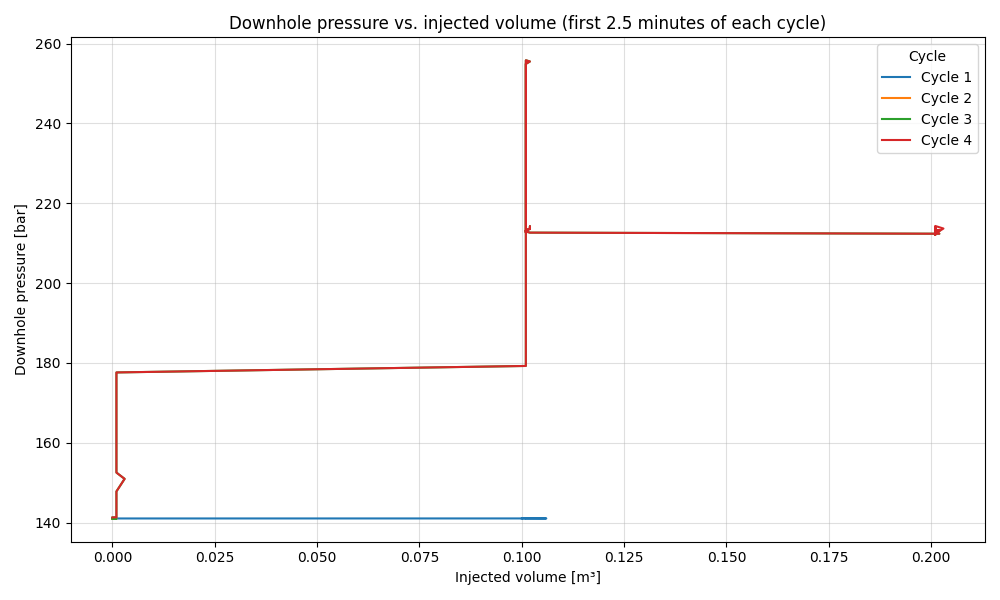

In [40]:
# =========================
# Plot P_dh vs Volume for ALL detected cycles
# =========================

fig, ax = plt.subplots(figsize=(10, 6))

for i, cyc in enumerate(cycles_df.itertuples(index=False), start=1):

    # Cycle start based on volume (surface time)
    t_start = pd.to_datetime(cyc.t_start)
    t_end_plot = t_start + pd.Timedelta(minutes=2.5)

    # Slice downhole pressure + volume over [start, start + 4 minutes]
    segP = combined["P_dh_at_frac_bar"].loc[
        (combined.index >= t_start) &
        (combined.index <= t_end_plot)
    ]
    segV = combined["volume"].loc[
        (combined.index >= t_start) &
        (combined.index <= t_end_plot)
    ]

    if segP.empty or segV.empty:
        print(f"Cycle {i}: no usable data found in this window.")
        continue

    # Plot Pressure vs Volume
    ax.plot(segV.values, segP.values, lw=1.5, label=f"Cycle {i}")

# --- Formatting ---
ax.set_xlabel("Injected volume [m³]")
ax.set_ylabel("Downhole pressure [bar]")
ax.set_title("Downhole pressure vs. injected volume (first 2.5 minutes of each cycle)")
ax.grid(True, alpha=0.4)
ax.legend(title="Cycle")

plt.tight_layout()
plt.show()

First cycle start: 2023-12-12 13:17:58, end: 2023-12-12 13:45:54
Quarter window: 2023-12-12 13:17:58 → 2023-12-12 13:24:57
Max pressure point: 2023-12-12 13:19:24

Linear regression (P = a·V + b):
  a = 4.556556e-01 bar/m³
  b = 1.410205e+02
  R² = 0.4381
→ Compliance = 2.194640e+00 m³/bar  (2194.640 L/bar)


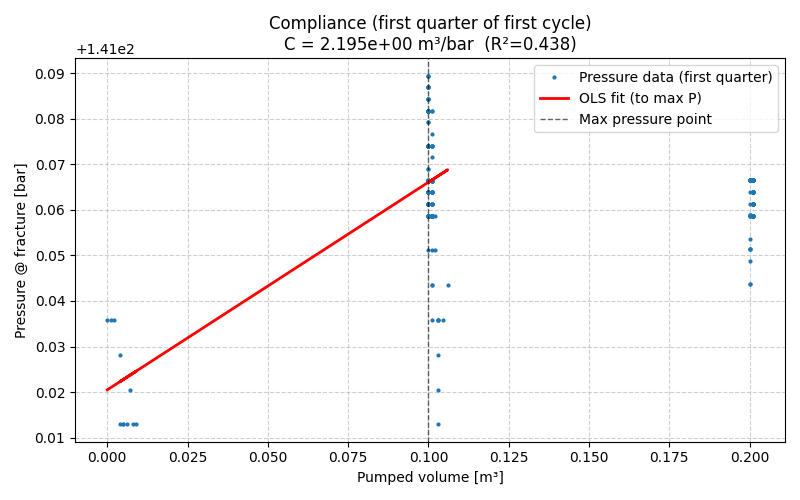

In [41]:
# ===========================================
# Compute compliance from first quarter of first cycle (P vs V)
# ===========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Detect cycles as before ---
cycles_df = detect_volume_cycles(
    combined["volume"],
    tol=1e-3,
    include_last_partial=True,
    skip_all_zero_leading=True,
    start_at=startD,
    end_at=endD
)

if len(cycles_df) == 0:
    raise RuntimeError("No pumping cycles detected – cannot compute compliance.")

# --- Select first cycle only ---
first_cyc = cycles_df.iloc[0]
t0 = pd.to_datetime(first_cyc.t_start)
t1 = pd.to_datetime(first_cyc.t_end)
t_quarter = t0 + (t1 - t0) / 4  # first quarter in time

# --- Subset to first quarter of first cycle ---
df_cyc = combined.loc[t0:t_quarter, ["volume", "P_dh_at_frac_bar"]].dropna()
if df_cyc.empty:
    raise RuntimeError("No valid data in first quarter of first cycle.")

# --- Find maximum pressure point ---
imax = df_cyc["P_dh_at_frac_bar"].idxmax()
df_fit = df_cyc.loc[:imax]  # first sample → max pressure

# --- Linear regression (P = a·V + b) ---
V = df_fit["volume"].values
P = df_fit["P_dh_at_frac_bar"].values
coeffs = np.polyfit(V, P, 1)
slope, intercept = coeffs  # slope = dP/dV
P_fit = np.poly1d(coeffs)

# --- Compliance ---
if slope != 0:
    C_m3_per_bar = 1.0 / slope      # m³/bar
    C_L_per_bar  = C_m3_per_bar * 1e3  # L/bar
else:
    C_m3_per_bar = np.nan
    C_L_per_bar  = np.nan

# --- R² calculation ---
residuals = P - P_fit(V)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((P - np.mean(P))**2)
r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

# --- Report ---
print(f"First cycle start: {t0}, end: {t1}")
print(f"Quarter window: {t0} → {t_quarter}")
print(f"Max pressure point: {imax}")
print("\nLinear regression (P = a·V + b):")
print(f"  a = {slope:.6e} bar/m³")
print(f"  b = {intercept:.6e}")
print(f"  R² = {r2:.4f}")
print(f"→ Compliance = {C_m3_per_bar:.6e} m³/bar  ({C_L_per_bar:.3f} L/bar)")

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df_cyc["volume"], df_cyc["P_dh_at_frac_bar"], 'o', ms=2, label="Pressure data (first quarter)")
ax.plot(df_fit["volume"], P_fit(df_fit["volume"]), 'r-', lw=2, label="OLS fit (to max P)")
ax.axvline(df_fit["volume"].iloc[-1], color='k', ls='--', lw=1, alpha=0.6, label="Max pressure point")

ax.set_xlabel("Pumped volume [m³]")
ax.set_ylabel("Pressure @ fracture [bar]")
ax.set_title(f"Compliance (first quarter of first cycle)\nC = {C_m3_per_bar:.3e} m³/bar  (R²={r2:.3f})")
ax.grid(True, ls='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

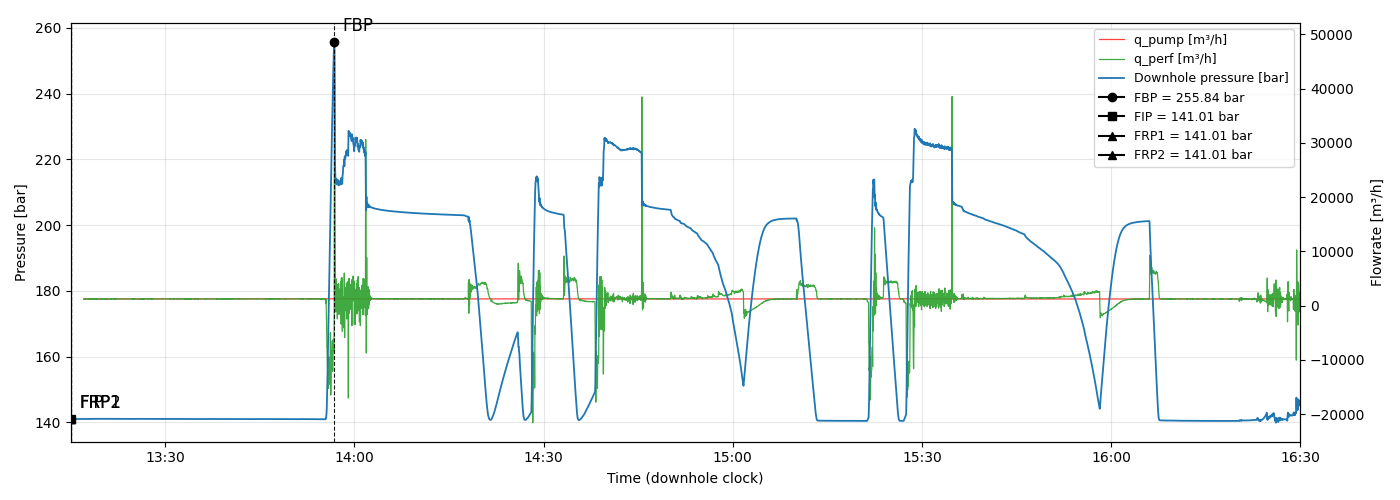

FBP: 255.84 bar at 2023-12-12 13:56:48
FIP: 141.01 bar at 2023-12-12 13:15:00
FRP1: 141.01 bar at 2023-12-12 13:15:00
FRP2: 141.01 bar at 2023-12-12 13:15:00


In [42]:
# ============================
# FIP / FBP / FRP overlay with q_pump, q_perf, and P_dh (downhole clock)
# ============================

import matplotlib.dates as mdates

# ---- Inputs (set these) ----
C_WELL = C_m3_per_bar  # m³/bar  (system/wellbore compliance used for q_perf calculation)

# Optional manual picks on the DOWNHOLE clock:
FIP_TIME    = pd.Timestamp("2023-12-10 14:17:22")
FRP_TIME_1  = pd.Timestamp("2023-12-10 15:44:55")
FRP_TIME_2  = pd.Timestamp("2023-12-10 16:02:55")

FRP_TIMES = [FRP_TIME_1, FRP_TIME_2]   # <- use both

# ---- Pull series (window-aware) ----
work = combined.loc[startD:endD]

# Downhole pressure [bar]
P_dh = (work["P_dh_at_frac_bar"]
        .astype(float)
        .sort_index())
P_dh = P_dh[~P_dh.index.duplicated(keep="first")].interpolate(
    "time", limit_direction="both"
)

# Pump rate in data is L/min → convert to m³/h
q_pump_Lmin = pd.to_numeric(work["flow_rate"], errors="coerce")  # L/min
q_pump_m3h  = q_pump_Lmin * 0.06  # m³/h

# ---- dP/dt in bar/s ----
ts = (P_dh.index - P_dh.index[0]).total_seconds().to_numpy()
dPdt = np.gradient(P_dh.to_numpy(), ts)  # bar/s

# ---- q_perf on the DH clock: q_perf = q_pump - C * dP/dt ----
# Convert q_pump to m³/s, subtract C*dPdt (m³/s), then back to m³/h
q_perf_m3h = (q_pump_m3h.to_numpy() / 3600.0 - C_WELL * dPdt) * 3600.0

# ---- Helper: robust time interpolation on DH-indexed series ----
def _interp_time(series_dt: pd.Series, t_query: pd.Timestamp):
    s = series_dt.sort_index()
    s = s[~s.index.duplicated(keep="first")].interpolate(
        method="time", limit_direction="both"
    )
    t_min, t_max = s.index.min(), s.index.max()
    tq = min(max(pd.Timestamp(t_query), t_min), t_max)
    val = s.reindex(s.index.union([tq])).interpolate(method="time").loc[tq]
    return tq, float(val)

# ---- Picks ----
# FBP: maximum downhole pressure
t_FBP = P_dh.idxmax()
FBP_bar = float(P_dh.loc[t_FBP])

# FIP from user timestamp (if provided)
FIP_info = None
if FIP_TIME is not None:
    t_FIP_q, P_FIP = _interp_time(P_dh, pd.Timestamp(FIP_TIME))
    FIP_info = (t_FIP_q, P_FIP)

# FRPs from both user timestamps
FRP_infos = []
for t_FRP in FRP_TIMES:
    if t_FRP is None:
        continue
    t_FRP_q, P_FRP = _interp_time(P_dh, pd.Timestamp(t_FRP))
    FRP_infos.append((t_FRP_q, P_FRP))

# ---- Scale flows to pressure axis (so they can share ax1 cleanly) ----
q_all = np.concatenate([q_pump_m3h.to_numpy(), q_perf_m3h])
q_min = np.nanmin(q_all); q_max = np.nanmax(q_all)
if (not np.isfinite(q_min)) or (not np.isfinite(q_max)) or (q_max == q_min):
    q_min, q_max = 0.0, 1.0
q_rng = q_max - q_min

P_min = np.nanmin(P_dh.values); P_max = np.nanmax(P_dh.values)
if (not np.isfinite(P_min)) or (not np.isfinite(P_max)) or (P_max == P_min):
    P_min, P_max = 0.0, 1.0
P_rng = P_max - P_min

q_pump_scaled = (q_pump_m3h.to_numpy() - q_min) / q_rng * P_rng + P_min
q_perf_scaled = (q_perf_m3h - q_min) / q_rng * P_rng + P_min

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(14, 5))

t_dh = P_dh.index

# bottom → top layering
ax1.plot(t_dh, q_pump_scaled, color="red", lw=0.9, alpha=0.75, zorder=1,
         label="q_pump [m³/h]")
ax1.plot(t_dh, q_perf_scaled, color="C2", lw=0.9, alpha=0.9, zorder=2,
         label="q_perf [m³/h]")
ax1.plot(t_dh, P_dh,          color="C0", lw=1.3, zorder=3,
         label="Downhole pressure [bar]")

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.set_xlabel("Time (downhole clock)")
ax1.set_ylabel("Pressure [bar]")
ax1.grid(True, alpha=0.3)

# Secondary y-axis with true flow units
ax2 = ax1.twinx()
ax2.set_ylim(q_min, q_max)
ax2.set_ylabel("Flowrate [m³/h]")
ax2.tick_params(axis="y")

# ========= Vertical lines & markers =========

# FBP
ax1.axvline(t_FBP, color="black", linestyle="--", lw=0.8, alpha=0.9, zorder=4)
ax1.plot(t_FBP, FBP_bar, marker="o", ms=6, color="black", zorder=5,
         label=f"FBP = {FBP_bar:.2f} bar")
ax1.annotate("FBP", xy=(t_FBP, FBP_bar), xytext=(6, 8),
             textcoords="offset points", color="black",
             fontsize=12, zorder=6)

# FIP (optional)
if FIP_info is not None:
    t_FIP_q, P_FIP = FIP_info
    ax1.axvline(t_FIP_q, color="black", linestyle="--", lw=0.8, alpha=0.9, zorder=4)
    ax1.plot(t_FIP_q, P_FIP, marker="s", ms=6, color="black", zorder=5,
             label=f"FIP = {P_FIP:.2f} bar")
    ax1.annotate("FIP", xy=(t_FIP_q, P_FIP), xytext=(6, 8),
                 textcoords="offset points", color="black",
                 fontsize=12, zorder=6)

# FRPs (one marker/label per FRP)
for j, (t_FRP_q, P_FRP) in enumerate(FRP_infos, start=1):
    ax1.axvline(t_FRP_q, color="black", linestyle="--", lw=0.8,
                alpha=0.9, zorder=4)
    ax1.plot(t_FRP_q, P_FRP, marker="^", ms=6, color="black", zorder=5,
             label=f"FRP{j} = {P_FRP:.2f} bar")
    ax1.annotate(f"FRP{j}", xy=(t_FRP_q, P_FRP), xytext=(6, 8),
                 textcoords="offset points", color="black",
                 fontsize=12, zorder=6)

# Legend & limits
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, l, loc="best", fontsize=9)
ax1.set_xlim(startD, endD)

plt.tight_layout()
plt.show()

# ---- Console readout ----
print(f"FBP: {FBP_bar:.2f} bar at {t_FBP}")
if FIP_info is not None:
    print(f"FIP: {FIP_info[1]:.2f} bar at {FIP_info[0]}")
else:
    print("FIP: (not set) — set FIP_TIME to annotate")

if FRP_infos:
    for j, (t_FRP_q, P_FRP) in enumerate(FRP_infos, start=1):
        print(f"FRP{j}: {P_FRP:.2f} bar at {t_FRP_q}")
else:
    print("FRP: (not set) — set FRP_TIME_1 / FRP_TIME_2 to annotate")

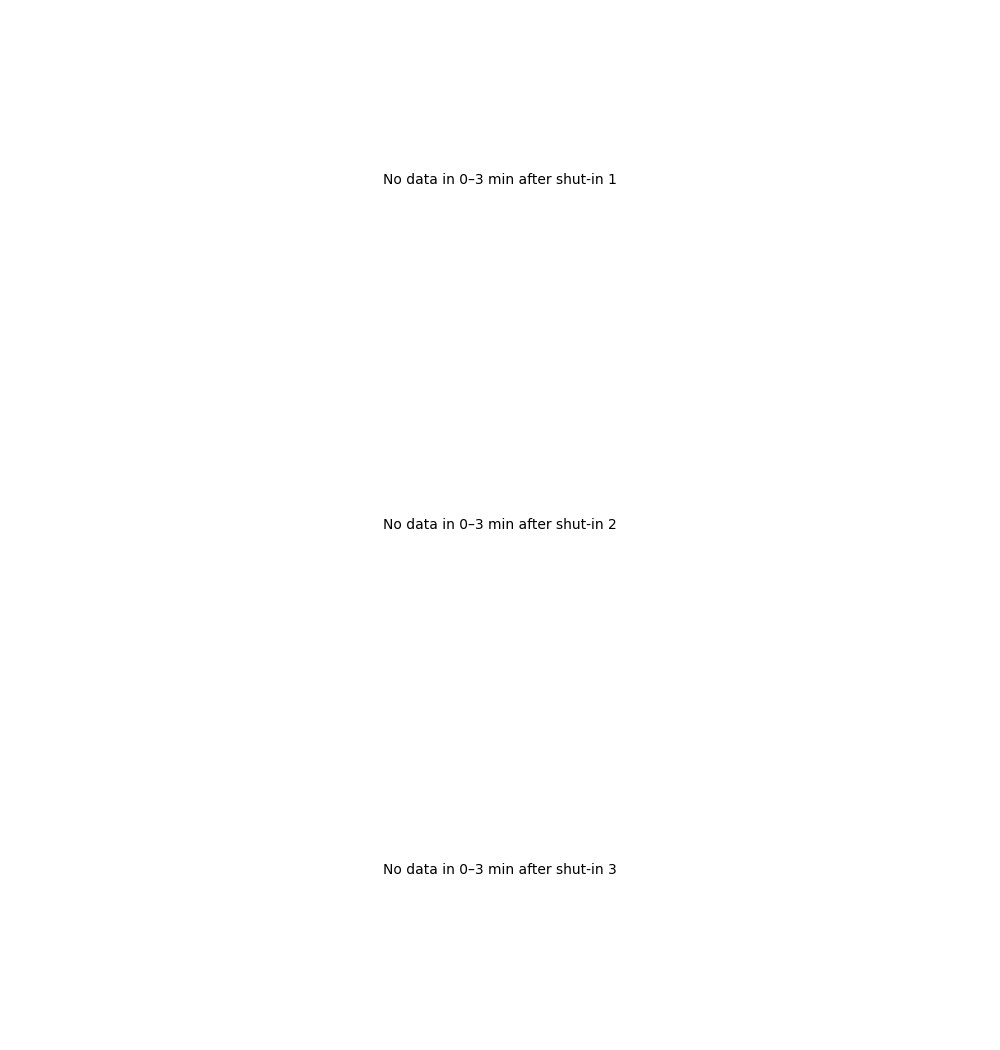

In [43]:
# ============================
# Settings
# ============================

# Duration of falloff window
FALLOFF_WINDOW = pd.Timedelta(minutes=3)

# Shut-in times on the DOWNHOLE clock, defined as the start of this notebook

# ============================
# Plot falloffs: one subplot per shut-in
# ============================

P_series = combined["P_dh_at_frac_bar"].astype(float)  # downhole @ fracture, bar
P_series = P_series.sort_index()

n = len(MANUAL_SHUTINS_DH)
if n == 0:
    print("No shut-in times defined – nothing to plot.")
else:
    fig, axes = plt.subplots(n, 1, figsize=(10, 3.5*n), squeeze=False)
    axes = axes.ravel()

    for i, (ax, t_si) in enumerate(zip(axes, MANUAL_SHUTINS_DH), start=1):
        t_si = pd.to_datetime(t_si)

        # Window: [shut-in, shut-in + 3 min]
        t_start = t_si
        t_end   = t_si + FALLOFF_WINDOW

        # Slice pressure series in that window
        p_seg = P_series.loc[(P_series.index >= t_start) & (P_series.index <= t_end)].dropna()

        if p_seg.empty:
            ax.text(0.5, 0.5,
                    f"No data in 0–3 min after shut-in {i}",
                    ha="center", va="center", transform=ax.transAxes)
            ax.set_axis_off()
            continue

        # Time axis as minutes since shut-in
        t_rel_min = (p_seg.index - t_start) / pd.Timedelta(minutes=1)

        # Plot
        ax.plot(t_rel_min, p_seg, lw=1.5, color="tab:blue")
        ax.axvline(0.0, color="k", ls="--", lw=1.0, alpha=0.7)

        # Labels & title
        ax.set_xlabel("Time since shut-in [min]")
        ax.set_ylabel("Downhole pressure [bar]")
        ax.set_title(
            f"Falloff {i}: first 3 min after shut-in\n"
            f"Shut-in at {t_start:%Y-%m-%d %H:%M:%S}"
        )
        ax.grid(True, which="both", linestyle="--", alpha=0.5)

        # Optional: tighten x-limits exactly to [0, 3]
        ax.set_xlim(0, FALLOFF_WINDOW / pd.Timedelta(minutes=1))

    plt.tight_layout()
    plt.show()

In [44]:
def g_nolte_delta_tD(delta_t_since_shutin_s, t_p_seconds, alpha=0.5):
    """
    Nolte / Carter g-function g(Δt) for leakoff, where:

        Δt = t - t_shutin   (time since shut-in, in seconds)
        t_p = injection time (pumping duration from start of injection into fracture
                              until shut-in), in seconds

    Dimensionless variable:
        u = Δt / t_p  >= 0

    For α = 1/2 (Carter-type leakoff with constant-height fracture), the "most common"
    form (Gulrajani & Nolte, 2001) is:

        g(Δt) = 4/3 * [ (1 + u)^(3/2) - u^(3/2) ],   u = Δt / t_p

    We also include an upper bound for α = 1 (different growth assumption), and for
    0.5 < α < 1 we linearly interpolate between the two shapes:

        g_lower(u) = 4/3 * [ (1 + u)^(3/2) - u^(3/2) ]
        g_upper(u) = (1 + u) * arcsin( (1 + u)^(-1/2) ) + u^(1/2)

    Parameters
    ----------
    delta_t_since_shutin_s : array-like
        Time since shut-in Δt (seconds). Δt = 0 at shut-in.
    t_p_seconds : float
        Injection time t_p (seconds) for that cycle.
    alpha : float in [0.5, 1]
        Shape parameter (0.5 = lower bound, 1 = upper bound, interpolate in between).

    Returns
    -------
    g : np.ndarray
        Dimensionless g-function values g(Δt) at the given Δt / t_p.
    """
    import numpy as np

    delta_t_since_shutin_s = np.asarray(delta_t_since_shutin_s, dtype=float)
    t_p_seconds = float(t_p_seconds)
    if t_p_seconds <= 0:
        raise ValueError("t_p_seconds must be positive (injection duration).")

    # u = Δt / t_p  (dimensionless time since shut-in)
    u = np.clip(delta_t_since_shutin_s / t_p_seconds, 0.0, None)

    # Lower bound α = 1/2
    g_lower = (4.0 / 3.0) * ((1.0 + u)**1.5 - u**1.5)

    # Upper bound α = 1
    with np.errstate(invalid="ignore"):
        g_upper = (1.0 + u) * np.arcsin(1.0 / np.sqrt(1.0 + u)) + np.sqrt(u)

    alpha_clamped = min(max(alpha, 0.5), 1.0)
    if np.isclose(alpha_clamped, 0.5):
        return g_lower
    if np.isclose(alpha_clamped, 1.0):
        return g_upper

    w = (alpha_clamped - 0.5) / 0.5   # 0 at 0.5, 1 at 1
    return g_lower + w * (g_upper - g_lower)

In [45]:
# -------------------------------------------
# 1) Injection durations per cycle (downhole clock)
# -------------------------------------------

# Start picks on DH clock (must already be defined)
cycle_start_times = [
    FIP_TIME,      # Cycle 1 starts at FIP
    FRP_TIME_1,    # Cycle 2 starts at first FRP
    FRP_TIME_2,    # Cycle 3 starts at second FRP
]

rows = []
for i, (t_start, t_shut) in enumerate(zip(cycle_start_times, MANUAL_SHUTINS_DH), start=1):
    if t_start is None or t_shut is None:
        print(f"Cycle {i}: missing start or shut-in time, skipping.")
        continue

    t_start = pd.to_datetime(t_start)
    t_shut  = pd.to_datetime(t_shut)

    if t_shut <= t_start:
        print(f"Cycle {i}: shut-in time ≤ start time, skipping.")
        continue

    duration   = t_shut - t_start
    duration_s = duration.total_seconds()

    rows.append({
        "cycle":      i,
        "t_start":    t_start,
        "t_shut":     t_shut,
        "duration":   duration,
        "duration_s": duration_s,
    })

inj_cycles_df = pd.DataFrame(rows, columns=["cycle", "t_start", "t_shut", "duration", "duration_s"])

print("Injection durations per cycle (downhole clock):")
display(inj_cycles_df)

# -------------------------------------------
# 2) Build inj_cycles dict from inj_cycles_df
# -------------------------------------------

inj_cycles = {}  # cycle_index -> dict with times & tp

for row in inj_cycles_df.itertuples(index=False):
    cyc_id     = int(row.cycle)
    t_start    = pd.to_datetime(row.t_start)
    t_shut     = pd.to_datetime(row.t_shut)
    duration_s = float(row.duration_s)

    if duration_s <= 0:
        print(f"Cycle {cyc_id}: non-positive duration in inj_cycles_df, skipping.")
        continue
    if t_shut <= t_start:
        print(f"Cycle {cyc_id}: t_shut <= t_start in inj_cycles_df, skipping.")
        continue

    inj_cycles[cyc_id] = {
        "t_inj_start":  t_start,                   # start of injection into fracture
        "t_shut":       t_shut,                    # shut-in time
        "t_p_seconds":  duration_s,                # injection duration t_p
        "t_fall_start": t_shut,                    # falloff starts at shut-in
        "t_fall_end":   t_shut + timedelta(minutes=3),  # first 3 minutes of falloff
    }

print(f"Built inj_cycles for {len(inj_cycles)} cycles from inj_cycles_df.")

# -------------------------------------------
# 3) Compute g(Δt), G(Δt) for each cycle → G_cycles
# -------------------------------------------

ALPHA_G = 0.5  # Carter lower bound; you can change to 1.0 or interpolate

G_cycles = {}   # cycle_index -> DataFrame with Δt, tD, g, G, P

P_dh_full = combined["P_dh_at_frac_bar"].astype(float)

for cyc_id, info in inj_cycles.items():
    t_shut      = info["t_shut"]
    t_fall_start = info["t_fall_start"]
    t_fall_end   = info["t_fall_end"]
    t_p_seconds  = info["t_p_seconds"]   # injection duration t_p

    # Segment of falloff data
    seg = P_dh_full.loc[t_fall_start:t_fall_end].dropna()
    if seg.empty:
        print(f"Cycle {cyc_id}: no data in falloff window {t_fall_start} → {t_fall_end}.")
        continue

    df = seg.to_frame(name="P_dh_at_frac_bar")

    # Δt = time since shut-in, in seconds
    delta_t_s = (df.index - t_shut).total_seconds()
    df["delta_t_s"] = delta_t_s
    df["tD"]        = delta_t_s / t_p_seconds   # dimensionless Δt/t_p

    # g(Δt) from Nolte/Carter
    g_vals = g_nolte_delta_tD(delta_t_s, t_p_seconds, alpha=ALPHA_G)
    df["g"] = g_vals

    # g(0) is g at Δt=0 → first sample at/after shut-in
    g0 = float(g_vals[0])

    # G(Δt) = 4/π [g(Δt) - g(0)]
    G_vals = (4.0 / np.pi) * (g_vals - g0)
    df["G"] = G_vals

    G_cycles[cyc_id] = df

# Quick check print
for cyc_id in sorted(G_cycles.keys()):
    df = G_cycles[cyc_id]
    print(f"\nCycle {cyc_id}:")
    print(df[["delta_t_s", "tD", "g", "G", "P_dh_at_frac_bar"]].head())

# -------------------------------------------
# 4) ONE FIGURE PER CYCLE: Δt, √Δt, G(Δt) stacked x-axes
# -------------------------------------------

if not G_cycles:
    print("No G-function data available. Make sure G_cycles is filled first.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        # time since shut-in in seconds
        dt_s = df["delta_t_s"].to_numpy()
        P    = df["P_dh_at_frac_bar"].to_numpy()
        Gval = df["G"].to_numpy()

        # keep only finite points
        mask = np.isfinite(dt_s) & np.isfinite(P) & np.isfinite(Gval)
        dt_s = dt_s[mask]
        P    = P[mask]
        Gval = Gval[mask]

        if dt_s.size == 0:
            print(f"Cycle {cyc_id}: no valid points to plot.")
            continue

        # time transforms
        dt_min      = dt_s / 60.0           # Δt in minutes
        sqrt_dt_min = np.sqrt(dt_min)       # √Δt [min^0.5]

        fig = plt.figure(figsize=(9, 6))
        fig.subplots_adjust(bottom=0.25)    # space for extra x-axes

        # Base axis: P vs Δt
        ax_t = fig.add_subplot(111)
        line_t, = ax_t.plot(dt_min, P, color="C0", lw=1.4, label="Δt")
        ax_t.set_ylabel("Pressure [bar]")
        ax_t.set_xlabel("Δt [min]")
        ax_t.set_title(f"Cycle {cyc_id}: falloff time transforms")
        ax_t.grid(True, linestyle="--", alpha=0.5)
        ax_t.set_xlim(dt_min.min(), dt_min.max())

        # Second x-axis: √Δt (below main)
        ax_sqrt = ax_t.twiny()
        line_sqrt, = ax_sqrt.plot(sqrt_dt_min, P, color="C1", lw=1.4, label="√Δt")

        ax_sqrt.spines["top"].set_visible(False)
        ax_sqrt.xaxis.set_ticks_position("bottom")
        ax_sqrt.xaxis.set_label_position("bottom")
        ax_sqrt.spines["bottom"].set_position(("axes", -0.20))
        ax_sqrt.patch.set_alpha(0.0)
        ax_sqrt.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
        ax_sqrt.yaxis.set_visible(False)
        ax_sqrt.set_xlim(sqrt_dt_min.min(), sqrt_dt_min.max())

        # Third x-axis: G(Δt) (below √Δt axis)
        ax_G = ax_t.twiny()
        line_G, = ax_G.plot(Gval, P, color="C2", lw=1.4, label="G(Δt)")

        ax_G.spines["top"].set_visible(False)
        ax_G.xaxis.set_ticks_position("bottom")
        ax_G.xaxis.set_label_position("bottom")
        ax_G.spines["bottom"].set_position(("axes", -0.40))
        ax_G.patch.set_alpha(0.0)
        ax_G.set_xlabel(r"$G(\Delta t)$")
        ax_G.yaxis.set_visible(False)

        if np.isfinite(Gval.min()) and np.isfinite(Gval.max()) and Gval.max() > Gval.min():
            ax_G.set_xlim(Gval.min(), Gval.max())

        # Combined legend
        handles = [line_t, line_sqrt, line_G]
        labels  = ["Δt", r"$\sqrt{\Delta t}$", r"$G(\Delta t)$"]
        ax_t.legend(handles, labels, loc="upper right", fontsize=9)

        plt.tight_layout()
        plt.show()

#Check if G-function is computed correctly!

Injection durations per cycle (downhole clock):


,cycle,t_start,t_shut,duration,duration_s
0,1,2023-12-10 14:17:22,2023-12-11 14:23:45,1 days 00:06:23,86783.0
1,2,2023-12-10 15:44:55,2023-12-11 15:45:30,1 days 00:00:35,86435.0
2,3,2023-12-10 16:02:55,2023-12-11 16:13:48,1 days 00:10:53,87053.0


Built inj_cycles for 3 cycles from inj_cycles_df.
Cycle 1: no data in falloff window 2023-12-11 14:23:45 → 2023-12-11 14:26:45.
Cycle 2: no data in falloff window 2023-12-11 15:45:30 → 2023-12-11 15:48:30.
Cycle 3: no data in falloff window 2023-12-11 16:13:48 → 2023-12-11 16:16:48.
No G-function data available. Make sure G_cycles is filled first.


# Castillo

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Any


# ------------------------------
# Dataclass for Castillo results
# ------------------------------
@dataclass
class CastilloCycleResult:
    G: np.ndarray
    P: np.ndarray
    t_s: np.ndarray
    dP_dG: np.ndarray
    idx_open_start: int
    idx_open_end: int
    P_star: float
    P_isip_theoretical: float
    idx_closure: Optional[int]
    P_closure: Optional[float]
    r2_open: float


# -----------------------------------------------------
# Rolling derivative: local linear regression (Castillo)
# -----------------------------------------------------
def castillo_rolling_dP_dG(G: np.ndarray, P: np.ndarray, window: int = 7) -> np.ndarray:
    """
    Rolling dP/dG using local linear regression (Castillo 1987 style).
    """
    G = np.asarray(G, float)
    P = np.asarray(P, float)

    if window % 2 == 0:
        window += 1
    half = window // 2

    d = np.full_like(G, np.nan)

    for i in range(half, len(G) - half):
        g_win = G[i-half:i+half+1]
        p_win = P[i-half:i+half+1]
        A = np.vstack([g_win, np.ones_like(g_win)]).T
        m, _ = np.linalg.lstsq(A, p_win, rcond=None)[0]
        d[i] = m
    return d


# ------------------------------
# Main Castillo analysis (1 cycle)
# ------------------------------
def castillo_analyze_cycle_df(
    df_cycle: pd.DataFrame,
    col_t: str = "delta_t_s",
    col_G: str = "G",
    col_P: str = "P_dh_at_frac_bar",
    open_frac_window=(0.1, 0.5),   # <-- YOU control open-fracture window here
    deriv_window: int = 7,
    deriv_tol_rel: float = 0.10,
    t_min_for_linear: float = 0.0,  # skip very early time if you want
) -> CastilloCycleResult:
    """
    Castillo (1987) G-function analysis on a single cycle.

    open_frac_window = (g_start_frac, g_end_frac) defines the open-fracture window
    as a fraction of the G-range AFTER t >= t_min_for_linear.
    Example: (0.1, 0.5) → use G between 10% and 50% of the G-range.

    Parameters
    ----------
    df_cycle : DataFrame
        Must contain at least: col_t, col_G, col_P.
    col_t, col_G, col_P : str
        Column names for time since shut-in, G-function, and pressure.
    open_frac_window : (float, float)
        Fraction of G-range to define open-fracture region.
    deriv_window : int
        Window length (points) for rolling dP/dG regression.
    deriv_tol_rel : float
        Relative deviation from early-time dP/dG mean to declare closure.
    t_min_for_linear : float
        Minimum Δt (seconds since shut-in) to include in the open-fracture window
        (skips very early ISIP region if > 0).

    Returns
    -------
    CastilloCycleResult
    """
    # 1) Extract arrays
    t_s = df_cycle[col_t].to_numpy(float)   # Δt since shut-in [s]
    G = df_cycle[col_G].to_numpy(float)
    P = df_cycle[col_P].to_numpy(float)

    # NaN-safe
    mask = np.isfinite(t_s) & np.isfinite(G) & np.isfinite(P)
    t_s = t_s[mask]
    G = G[mask]
    P = P[mask]

    if len(G) < max(deriv_window + 5, 10):
        raise ValueError("Not enough points in cycle for Castillo analysis.")

    # 2) Rolling derivative dP/dG
    dP_dG = castillo_rolling_dP_dG(G, P, window=deriv_window)

    # 3) Define open-fracture window in terms of G-range and t_min_for_linear
    G_min, G_max = np.nanmin(G), np.nanmax(G)
    g_start_frac, g_end_frac = open_frac_window
    g_start = G_min + g_start_frac * (G_max - G_min)
    g_end   = G_min + g_end_frac   * (G_max - G_min)

    open_mask = (G >= g_start) & (G <= g_end) & (t_s >= t_min_for_linear)
    open_idx = np.where(open_mask)[0]

    if len(open_idx) < 5:
        raise ValueError(
            f"Open-fracture window has too few points. "
            f"Try different open_frac_window or t_min_for_linear."
        )

    idx_open_start = int(open_idx[0])
    idx_open_end   = int(open_idx[-1])

    # 4) Linear regression P vs G in open-fracture window → P* and theoretical ISIP
    Gw = G[open_mask]
    Pw = P[open_mask]
    A = np.vstack([Gw, np.ones_like(Gw)]).T
    P_star, P_isip = np.linalg.lstsq(A, Pw, rcond=None)[0]

    # Compute R² for this linear fit (for info)
    P_pred = P_star * Gw + P_isip
    ss_res = np.sum((Pw - P_pred)**2)
    ss_tot = np.sum((Pw - np.mean(Pw))**2)
    r2_open = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # 5) Closure: first deviation of dP/dG from early-time mean in the open window
    # Use ~first half of open window as "early plateau"
    early_end = idx_open_start + max(5, (idx_open_end - idx_open_start) // 2)
    d_early = dP_dG[idx_open_start:early_end]
    d_early = d_early[np.isfinite(d_early)]
    d_mean = np.mean(d_early) if len(d_early) else np.nan

    idx_closure = None
    P_closure = None

    if np.isfinite(d_mean):
        lower = d_mean * (1.0 - deriv_tol_rel)
        upper = d_mean * (1.0 + deriv_tol_rel)

        for i in range(idx_open_end + 1, len(dP_dG)):
            val = dP_dG[i]
            if not np.isfinite(val):
                continue
            if (val < lower) or (val > upper):
                idx_closure = int(i)
                P_closure = float(P[i])
                break

    return CastilloCycleResult(
        G=G,
        P=P,
        t_s=t_s,
        dP_dG=dP_dG,
        idx_open_start=idx_open_start,
        idx_open_end=idx_open_end,
        P_star=float(P_star),
        P_isip_theoretical=float(P_isip),
        idx_closure=idx_closure,
        P_closure=P_closure,
        r2_open=float(r2_open),
    )


# ------------------------------
# Plotting for one cycle
# ------------------------------
def plot_castillo_cycle(df_cycle: pd.DataFrame,
                        res: CastilloCycleResult,
                        title: str = ""):

    G = res.G
    P = res.P
    t_s = res.t_s
    dP_dG = res.dP_dG

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

    # ------ P vs G ------
    ax1.plot(G, P, ".", label="Data")
    G_line = np.linspace(np.nanmin(G), np.nanmax(G), 200)
    P_line = res.P_star * G_line + res.P_isip_theoretical
    ax1.plot(G_line, P_line, "-", label=f"Linear fit (R²={res.r2_open:.3f})")

    # Open-fracture window
    ax1.axvspan(G[res.idx_open_start], G[res.idx_open_end],
                color="lightgrey", alpha=0.4, label="Open-fracture window")

    # Closure point
    if res.idx_closure is not None:
        ax1.axvline(G[res.idx_closure], color="r", linestyle="--")
        ax1.plot(G[res.idx_closure], P[res.idx_closure], "ro",
                 label=f"Closure ≈ {res.P_closure:.1f} bar")

    # Theoretical ISIP at G=0 (horizontal line)
    ax1.axhline(res.P_isip_theoretical, color="k", linestyle="--",
                label=f"ISIP_th ≈ {res.P_isip_theoretical:.1f} bar")

    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")
    if title:
        ax1.set_title(title)
    ax1.legend(loc="best")

    # ------ dP/dG vs Δt ------
    ax2.plot(t_s, dP_dG, ".-", label="dP/dG (rolling regression)")
    if res.idx_closure is not None:
        ax2.axvline(t_s[res.idx_closure], color="r", linestyle="--",
                    label="Closure time")
    ax2.set_xlabel("Δt since shut-in [s]")
    ax2.set_ylabel("dP/dG")
    ax2.legend(loc="best")

    fig.tight_layout()
    return fig


In [47]:
def plot_castillo_cycle(df_cycle: pd.DataFrame,
                        res: CastilloCycleResult,
                        title: str = ""):

    G = res.G
    P = res.P
    t_s = res.t_s
    dP_dG = res.dP_dG

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

    # ------ P vs G ------
    ax1.plot(G, P, ".", label="Data")
    G_line = np.linspace(min(G), max(G), 200)
    P_line = res.P_star * G_line + res.P_isip_theoretical
    ax1.plot(G_line, P_line, "-", label=f"Linear fit (R²={res.r2_open:.3f})")

    ax1.axvspan(G[res.idx_open_start], G[res.idx_open_end],
                color="lightgrey", alpha=0.4, label="Open-fracture window")

    if res.idx_closure is not None:
        ax1.axvline(G[res.idx_closure], color="r", linestyle="--")
        ax1.plot(G[res.idx_closure], P[res.idx_closure], "ro",
                 label=f"Closure ≈ {res.P_closure:.1f} bar")

    ax1.axhline(res.P_isip_theoretical, color="k", linestyle="--",
                label=f"ISIP_th ≈ {res.P_isip_theoretical:.1f} bar")

    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")
    if title:
        ax1.set_title(title)
    ax1.legend()
    ax1.grid(True, linestyle="--", alpha=0.5)

    # ------ dP/dG ------
    ax2.plot(t_s, -dP_dG, ".-", label="dP/dG")
    if res.idx_closure is not None:
        ax2.axvline(t_s[res.idx_closure], color="r", linestyle="--",
                    label="Closure")
    ax2.set_xlabel("Δt since shut-in [s]")
    ax2.set_ylabel("-dP/dG")
    ax2.legend()
    ax2.grid(True, linestyle="--", alpha=0.5)

    fig.tight_layout()
    return fig

In [48]:
castillo_results = {}

for cyc_id, df in G_cycles.items():
    try:
        res = castillo_analyze_cycle_df(
            df,
            col_t="delta_t_s",
            col_G="G",
            col_P="P_dh_at_frac_bar",
            open_frac_window=(0, 0.05),  # <-- SET YOUR OPEN-FRACTURE WINDOW HERE
            deriv_window=7,               # smoothing for dP/dG
            deriv_tol_rel=0,                # closure sensitivity
            t_min_for_linear=0          # ignore first 5 s after shut-in
        )
    except Exception as e:
        print(f"Cycle {cyc_id}: Castillo analysis failed – {e}")
        print("  Reason:", e)
        continue

    castillo_results[cyc_id] = res
    plot_castillo_cycle(df, res, title=f"Castillo – Cycle {cyc_id}")

    print(f"Cycle {cyc_id}:")
    print(f"  P* (match pressure)          = {res.P_star:.2f} bar")
    print(f"  ISIP_th (G→0)                = {res.P_isip_theoretical:.2f} bar")
    if res.P_closure is not None:
        print(f"  Castillo closure pressure    = {res.P_closure:.2f} bar\n")
    else:
        print("  No closure detected.\n")

# Haimson

In [49]:
import numpy as np

def bilinear_model_anchored(P, m1, m2, P_break, P_anchor, Y_anchor):
    """
    Continuous bilinear model with the LEFT segment anchored at (P_anchor, Y_anchor):

        For P <= P_break:  Y = Y_break + m1 * (P - P_break)
        For P >  P_break:  Y = Y_break + m2 * (P - P_break)

    with Y_break determined by requiring the left segment to pass exactly through
    (P_anchor, Y_anchor):

        Y_anchor = Y_break + m1 * (P_anchor - P_break)
        -> Y_break = Y_anchor - m1 * (P_anchor - P_break)
    """
    P = np.asarray(P, dtype=float)

    Y_break = Y_anchor - m1 * (P_anchor - P_break)

    Y = np.empty_like(P)
    mask_left = P <= P_break
    mask_right = ~mask_left

    Y[mask_left]  = Y_break + m1 * (P[mask_left]  - P_break)
    Y[mask_right] = Y_break + m2 * (P[mask_right] - P_break)

    return Y


def haimson_bilinear_fit_anchored(P, Y, min_seg_size=5, skip_high_n=0, trim_frac=0.3):
    """
    Haimson-style bilinear fit of Y vs P using a discrete breakpoint search,
    with the LOW-PRESSURE segment (left) anchored at the lowest-P datapoint.

    IMPORTANT: For the regressions that determine slopes and breakpoint:

      - Left segment: drops the LAST `trim_frac` of points (the right side of the left segment).
      - Right segment: drops the FIRST `trim_frac` of points (the left side of the right segment).

    This means the breakpoint P_break (FCP) is influenced only by the
    "interior" 70% of each segment, as requested.

    Parameters
    ----------
    P : array-like
        Pressure values.
    Y : array-like
        Y = -dP/dt values.
    min_seg_size : int
        Minimum number of points on each side of the break BEFORE trimming.
    skip_high_n : int
        Number of highest-P points to remove from the fitting data entirely.
    trim_frac : float
        Fraction (0–1) of points to trim at the junctions of each segment.

    Returns
    -------
    dict or None
        Same structure as before:
            {
              "P_sorted", "Y_sorted",
              "m1", "m2", "P_break",
              "P_anchor", "Y_anchor", "Y_break",
              "Y_fit",
              "R2_all", "R2_left", "R2_right",
            }
        or None if the fit cannot be performed.
    """
    P = np.asarray(P, dtype=float)
    Y = np.asarray(Y, dtype=float)

    # drop NaNs/infs
    mask = np.isfinite(P) & np.isfinite(Y)
    P = P[mask]
    Y = Y[mask]
    if P.size == 0:
        return None

    # sort by pressure (ascending)
    sort_idx = np.argsort(P)
    P_sorted_all = P[sort_idx]
    Y_sorted_all = Y[sort_idx]

    # optionally drop the highest-pressure points from the fitting data
    if skip_high_n > 0:
        if P_sorted_all.size <= skip_high_n:
            return None
        P_sorted = P_sorted_all[:-skip_high_n]
        Y_sorted = Y_sorted_all[:-skip_high_n]
    else:
        P_sorted = P_sorted_all
        Y_sorted = Y_sorted_all

    n = P_sorted.size
    if n < 2 * min_seg_size + 2:
        return None

    # anchor point: lowest pressure datapoint (after skipping high points)
    P_anchor = P_sorted[0]
    Y_anchor = Y_sorted[0]

    # indices of possible breakpoints, ensuring at least min_seg_size points
    # on each side BEFORE trimming
    i_min = min_seg_size
    i_max = n - min_seg_size - 1
    if i_min >= i_max:
        return None

    best_sse = np.inf
    best_params = None
    best_i_break = None

    # scan over discrete break indices
    for i_break in range(i_min, i_max + 1):
        P_break = P_sorted[i_break]

        # left: indices 0..i_break  (inclusive)
        P_left = P_sorted[: i_break + 1]
        Y_left = Y_sorted[: i_break + 1]

        # right: indices i_break+1 .. end
        P_right = P_sorted[i_break + 1 :]
        Y_right = Y_sorted[i_break + 1 :]

        if P_left.size < min_seg_size or P_right.size < min_seg_size:
            continue

        # ----- trim segments -----
        def _trim_left(P_seg, Y_seg):
            n_seg = P_seg.size
            if n_seg < 2:
                return None, None
            n_trim = int(trim_frac * n_seg)
            end = max(n_seg - n_trim, 2)  # keep at least 2
            return P_seg[:end], Y_seg[:end]

        def _trim_right(P_seg, Y_seg):
            n_seg = P_seg.size
            if n_seg < 2:
                return None, None
            n_trim = int(trim_frac * n_seg)
            start = min(n_trim, n_seg - 2)  # keep at least 2
            return P_seg[start:], Y_seg[start:]

        P_left_fit, Y_left_fit = _trim_left(P_left, Y_left)
        P_right_fit, Y_right_fit = _trim_right(P_right, Y_right)

        if P_left_fit is None or P_right_fit is None:
            continue
        if P_left_fit.size < 2 or P_right_fit.size < 2:
            continue

        # ----- anchored regression on left: Y = Y_anchor + m1 (P - P_anchor) -----
        Xl = P_left_fit - P_anchor
        Yl = Y_left_fit - Y_anchor
        denom_l = np.sum(Xl**2)
        if denom_l <= 0:
            continue
        m1 = np.sum(Xl * Yl) / denom_l

        # Y_break from anchor condition
        Y_break = Y_anchor - m1 * (P_anchor - P_break)

        # ----- regression on right: Y = Y_break + m2 (P - P_break) -----
        Xr = P_right_fit - P_break
        Yr = Y_right_fit - Y_break
        denom_r = np.sum(Xr**2)
        if denom_r <= 0:
            continue
        m2 = np.sum(Xr * Yr) / denom_r

        # ----- compute SSE on the TRIMMED segments (what drives the breakpoint) -----
        Y_left_pred  = Y_anchor + m1 * (P_left_fit  - P_anchor)
        Y_right_pred = Y_break + m2 * (P_right_fit - P_break)

        sse_left  = np.sum((Y_left_fit  - Y_left_pred) ** 2)
        sse_right = np.sum((Y_right_fit - Y_right_pred) ** 2)
        sse_total = sse_left + sse_right

        if sse_total < best_sse:
            best_sse = sse_total
            best_params = (m1, m2, P_break, Y_break)
            best_i_break = i_break

    if best_params is None:
        return None

    m1, m2, P_break, Y_break = best_params

    # ----- build full-length fit over P_sorted_all -----
    Y_fit_full = bilinear_model_anchored(
        P_sorted_all, m1, m2, P_break, P_anchor, Y_anchor
    )

    # ----- compute R² on TRIMMED portions only (consistent with fit) -----
    # re-create the left/right sets for the winning breakpoint index
    P_left_all = P_sorted[: best_i_break + 1]
    Y_left_all = Y_sorted[: best_i_break + 1]
    P_right_all = P_sorted[best_i_break + 1 :]
    Y_right_all = Y_sorted[best_i_break + 1 :]

    P_left_fit, Y_left_fit = _trim_left(P_left_all, Y_left_all)
    P_right_fit, Y_right_fit = _trim_right(P_right_all, Y_right_all)

    def _R2(P_seg, Y_seg, m, P_break, Y_break, side):
        if P_seg is None or Y_seg is None or P_seg.size < 2:
            return np.nan
        if side == "left":
            Y_pred = Y_anchor + m * (P_seg - P_anchor)
        else:
            Y_pred = Y_break + m * (P_seg - P_break)
        ss_res = np.sum((Y_seg - Y_pred) ** 2)
        ss_tot = np.sum((Y_seg - Y_seg.mean()) ** 2)
        return 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    R2_left = _R2(P_left_fit,  Y_left_fit,  m1, P_break, Y_break, side="left")
    R2_right = _R2(P_right_fit, Y_right_fit, m2, P_break, Y_break, side="right")

    # "overall" R²: use trimmed segments combined
    if P_left_fit is not None and P_right_fit is not None:
        P_all_fit = np.concatenate([P_left_fit, P_right_fit])
        Y_all_fit = np.concatenate([Y_left_fit, Y_right_fit])
        Y_pred_all = np.concatenate([
            Y_anchor + m1 * (P_left_fit - P_anchor),
            Y_break + m2 * (P_right_fit - P_break),
        ])
        ss_res_all = np.sum((Y_all_fit - Y_pred_all) ** 2)
        ss_tot_all = np.sum((Y_all_fit - Y_all_fit.mean()) ** 2)
        R2_all = 1.0 - ss_res_all / ss_tot_all if ss_tot_all > 0 else np.nan
    else:
        R2_all = np.nan

    return {
        "P_sorted": P_sorted_all,   # full sorted P (including skipped highs)
        "Y_sorted": Y_sorted_all,   # full sorted Y
        "m1": m1,
        "m2": m2,
        "P_break": P_break,
        "P_anchor": P_anchor,
        "Y_anchor": Y_anchor,
        "Y_break": Y_break,
        "Y_fit": Y_fit_full,        # fit evaluated over all sorted P
        "R2_all": R2_all,
        "R2_left": R2_left,
        "R2_right": R2_right,
    }

In [50]:
# -------------------------------------------
# Haimson-style plot: dP/dt vs P (normal time, derivative in bar/sec)
#   + NLRA-style continuous bilinear regression in P
# -------------------------------------------

if not G_cycles:
    print("No G-function data available for dP/dt vs P plots.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        dt_s = df["delta_t_s"].to_numpy()     # Δt [sec]
        P    = df["P_dh_at_frac_bar"].to_numpy()

        mask = np.isfinite(dt_s) & np.isfinite(P)
        dt_s = dt_s[mask]
        P    = P[mask]

        if dt_s.size < 5:
            print(f"Cycle {cyc_id}: not enough points for dP/dt.")
            continue

        sort_idx_t = np.argsort(dt_s)
        dt_s = dt_s[sort_idx_t]
        P    = P[sort_idx_t]

        dPdt = np.gradient(P, dt_s)
        Y = -dPdt

        fit = haimson_bilinear_fit_anchored(P, Y, min_seg_size=5, skip_high_n=3)

        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(P, Y, marker="o", s=6, alpha=0.7, label="data")

        if fit is not None:
            P_sorted = fit["P_sorted"]   # full sorted P
            Y_fit    = fit["Y_fit"]
            P_break  = fit["P_break"]

            ax.plot(P_sorted, Y_fit, "r-", lw=1.5,
                    label="Anchored bilinear fit (skipping 3 highest P)")
            ax.axvline(P_break, color="k", ls="--", lw=1.0,
                       label=f"FCP ≈ {P_break:.2f} bar")

            print(
                f"Cycle {cyc_id}: Ps ≈ {P_break:.2f} bar "
                f"(R²_all={fit['R2_all']:.3f}, "
                f"R²_left={fit['R2_left']:.3f}, R²_right={fit['R2_right']:.3f})"
            )
        else:
            print(f"Cycle {cyc_id}: anchored bilinear fit failed or insufficient data.")

        ax.set_xlabel("Pressure [bar]")
        ax.set_ylabel("-dP/dt [bar/sec]")
        ax.set_title(f"Cycle {cyc_id}: -dP/dt vs P with Haimson-style bilinear fit")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(fontsize=8)

        plt.tight_layout()
        plt.show()

No G-function data available for dP/dt vs P plots.


# Barree (2009)

In [51]:
def semilog_derivative(x, P):
    """
    Compute semilog derivative: dP/dln(x) = x * dP/dx.
    Returns:
      x_valid, P_valid, dP_dlogx
    with x > 0 and finite.
    """
    x = np.asarray(x, dtype=float)
    P = np.asarray(P, dtype=float)

    mask = np.isfinite(x) & np.isfinite(P) & (x > 0.0)
    if not np.any(mask):
        return np.array([]), np.array([]), np.array([])

    x_valid = x[mask]
    P_valid = P[mask]

    dPdx = np.gradient(P_valid, x_valid)
    dP_dlogx = x_valid * dPdx

    return x_valid, P_valid, dP_dlogx

In [52]:
def semilog_derivative(x, P):
    """
    Compute semilog derivative: dP/dln(x) = x * dP/dx.
    Returns:
      x_valid, P_valid, dP_dlogx
    with x >= 0 and finite, including a value at shut-in (x=0).
    """
    x = np.asarray(x, dtype=float)
    P = np.asarray(P, dtype=float)

    # Allow x == 0 so we keep the shut-in point
    mask = np.isfinite(x) & np.isfinite(P) & (x >= 0.0)
    if not np.any(mask):
        return np.array([]), np.array([]), np.array([])

    x_valid = x[mask]
    P_valid = P[mask]

    # Numerical derivative dP/dx
    dPdx = np.gradient(P_valid, x_valid)

    # Avoid zero multiplier at shut-in: use next time step as "effective" x
    x_eff = x_valid.copy()
    if x_eff.size > 1 and x_eff[0] == 0.0:
        x_eff[0] = x_eff[1]

    dP_dlogx = x_eff * dPdx

    return x_valid, P_valid, dP_dlogx


def autoscale_semilog_axis(ax, y, lower=2, upper=98, margin=0.15):
    """
    Autoscale a derivative axis by robust percentiles (default 2–98%),
    BUT always ensure that y = 0 is included in the visible axis range.
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    if y.size == 0:
        return

    # percentile-based scaling
    y_lo = np.percentile(y, lower)
    y_hi = np.percentile(y, upper)

    # padding for comfort
    yr = y_hi - y_lo
    if yr <= 0:
        yr = max(abs(y_lo), abs(y_hi), 1e-6)

    y_lo_new = y_lo - margin * yr
    y_hi_new = y_hi + margin * yr

    # Ensure 0 is ALWAYS visible
    if y_lo_new > 0:
        y_lo_new = 0
    if y_hi_new < 0:
        y_hi_new = 0

    ax.set_ylim(y_lo_new, y_hi_new)


def _barree_tangent_and_fcp(x_arr, d_arr, P_arr, tol_rel=0.1):
    """
    Internal helper:
    - x_arr: x (dt_min, sqrt(dt_min), or G), including x>=0
    - d_arr: flipped semilog derivative, -dP/dln(x)
    - P_arr: pressure aligned with x_arr
    Returns:
      (m, x_touch, y_touch, x_fcp, P_fcp) where:
        m        : slope of tangent from origin
        x_touch  : x where tangent just touches -semilog (before its max)
        y_touch  : -semilog at x_touch
        x_fcp    : x where -semilog deviates from tangent (first point)
        P_fcp    : pressure at that x (FCP on pressure curve)
      Any of these can be None if not found.
    """
    x_bar = np.asarray(x_arr, dtype=float)
    y_bar = np.asarray(d_arr, dtype=float)
    P_bar = np.asarray(P_arr, dtype=float)

    mask_bar = (x_bar > 0.0) & np.isfinite(y_bar) & np.isfinite(P_bar)
    x_bar = x_bar[mask_bar]
    y_bar = y_bar[mask_bar]
    P_bar = P_bar[mask_bar]

    if x_bar.size <= 1:
        return None, None, None, None, None

    # 1) Find index of maximum -semilog value
    idx_max = int(np.nanargmax(y_bar))

    # 2) Restrict to points up to that max
    x_sub = x_bar[: idx_max + 1]
    y_sub = y_bar[: idx_max + 1]
    P_sub = P_bar[: idx_max + 1]

    mask_nz = x_sub > 0.0
    x_sub = x_sub[mask_nz]
    y_sub = y_sub[mask_nz]
    P_sub = P_sub[mask_nz]

    if x_sub.size == 0:
        return None, None, None, None, None

    # 3) Slope of line from origin to each candidate point
    slopes = y_sub / x_sub
    i_best = int(np.nanargmax(slopes))
    m = slopes[i_best]
    x_touch = x_sub[i_best]
    y_touch = y_sub[i_best]

    # 4) Tangent line over the full x-range
    x_line_full = x_bar  # use full domain for FCP detection
    y_tan_full = m * x_line_full

    # identify the index in x_bar that corresponds to x_touch
    # (x_touch came from x_sub, which is a subset of x_bar, so equality is OK)
    idx_touch_candidates = np.where(x_bar == x_touch)[0]
    idx_touch = int(idx_touch_candidates[0]) if idx_touch_candidates.size > 0 else 0

    # 5) FCP: first point AFTER touch where -semilog deviates downward
    # from the tangent by more than tol_rel * |tangent|
    x_fcp, P_fcp = None, None
    for i in range(idx_touch + 1, len(x_bar)):
        yt = y_tan_full[i]
        yd = y_bar[i]
        # skip near-zero tangent to avoid division noise
        if not np.isfinite(yt) or abs(yt) < 1e-9:
            continue
        if (yt - yd) > tol_rel * abs(yt):
            x_fcp = x_bar[i]
            P_fcp = P_bar[i]
            break

    return m, x_touch, y_touch, x_fcp, P_fcp


# -------------------------------------------
# 5) ONE FIGURE PER CYCLE: semilog derivatives (flipped) + Barree-style tangents + FCP
# -------------------------------------------

if not G_cycles:
    print("No G-function data available for semilog derivatives.")
else:
    for cyc_id in sorted(G_cycles.keys()):
        df = G_cycles[cyc_id].copy()

        dt_s = df["delta_t_s"].to_numpy()
        P    = df["P_dh_at_frac_bar"].to_numpy()
        Gval = df["G"].to_numpy()

        mask = np.isfinite(dt_s) & np.isfinite(P) & np.isfinite(Gval)
        dt_s = dt_s[mask]
        P    = P[mask]
        Gval = Gval[mask]

        if dt_s.size == 0:
            print(f"Cycle {cyc_id}: no valid points for semilog derivative.")
            continue

        dt_min      = dt_s / 60.0
        sqrt_dt_min = np.sqrt(dt_min)

        # semilog derivatives (including shut-in at x=0 if present)
        x_dt,   P_dt,   dP_dlog_dt    = semilog_derivative(dt_min,      P)
        x_sqrt, P_sqrt, dP_dlog_sqrt  = semilog_derivative(sqrt_dt_min, P)
        x_G,    P_G,    dP_dlog_G     = semilog_derivative(Gval,        P)

        # flipped for plotting
        dP_dlog_dt    = -dP_dlog_dt
        dP_dlog_sqrt  = -dP_dlog_sqrt
        dP_dlog_G     = -dP_dlog_G

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        fig.suptitle(f"Cycle {cyc_id}: flipped semilog derivatives + Barree-style tangents + FCP")

        # -------------------------------------------------
        # 1) Δt
        # -------------------------------------------------
        ax1 = axes[0]
        if x_dt.size > 0:
            lineP_dt, = ax1.plot(x_dt, P_dt, color="C0", lw=1.0, label="P(Δt)")
            ax1b = ax1.twinx()
            lineD_dt, = ax1b.plot(x_dt, dP_dlog_dt, color="C3", lw=1.0, ls="--",
                                  label="-dP/dln(Δt)")
            ax1.set_xlabel("Δt [min]")
            ax1.set_ylabel("Pressure [bar]")
            ax1b.set_ylabel("- dP/dln(Δt)")
            ax1.grid(True, linestyle="--", alpha=0.5)

            # Barree-style tangent and FCP
            m_dt, x_touch_dt, y_touch_dt, x_fcp_dt, P_fcp_dt = _barree_tangent_and_fcp(
                x_dt, dP_dlog_dt, P_dt, tol_rel=0.1
            )

            if m_dt is not None:
                # tangent from origin to end of curve
                x_line = np.array([0.0, x_dt.max()])
                y_line = m_dt * x_line
                lineTan_dt, = ax1b.plot(
                    x_line, y_line, color="k", ls="--", lw=1.0, label="Barree tangent"
                )

                # touch point on -semilog
                ax1b.scatter([x_touch_dt], [y_touch_dt], color="k", s=20, zorder=5)

                # FCP on pressure curve
                if x_fcp_dt is not None and P_fcp_dt is not None:
                    ax1.axvline(x_fcp_dt, color="k", ls=":", lw=1.0)
                    ax1.scatter([x_fcp_dt], [P_fcp_dt], color="k", s=30,
                                zorder=6, label=f"FCP ≈ {P_fcp_dt:.1f} bar")

            autoscale_semilog_axis(ax1b, dP_dlog_dt)

            # combined legend (pressure + derivative + tangent + FCP)
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax1b.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 2) √Δt
        # -------------------------------------------------
        ax2 = axes[1]
        if x_sqrt.size > 0:
            lineP_sqrt, = ax2.plot(x_sqrt, P_sqrt, color="C1", lw=1.0, label="P(√Δt)")
            ax2b = ax2.twinx()
            lineD_sqrt, = ax2b.plot(x_sqrt, dP_dlog_sqrt, color="C4", lw=1.0, ls="--",
                                    label="-dP/dln(√Δt)")
            ax2.set_xlabel(r"$\sqrt{\Delta t}$ [min$^{1/2}$]")
            ax2.set_ylabel("Pressure [bar]")
            ax2b.set_ylabel("- dP/dln(√Δt)")
            ax2.grid(True, linestyle="--", alpha=0.5)

            m_sqrt, x_touch_sqrt, y_touch_sqrt, x_fcp_sqrt, P_fcp_sqrt = _barree_tangent_and_fcp(
                x_sqrt, dP_dlog_sqrt, P_sqrt, tol_rel=0.1
            )

            if m_sqrt is not None:
                x_line = np.array([0.0, x_sqrt.max()])
                y_line = m_sqrt * x_line
                lineTan_sqrt, = ax2b.plot(
                    x_line, y_line, color="k", ls="--", lw=1.0, label="Barree tangent"
                )

                ax2b.scatter([x_touch_sqrt], [y_touch_sqrt], color="k", s=20, zorder=5)

                if x_fcp_sqrt is not None and P_fcp_sqrt is not None:
                    ax2.axvline(x_fcp_sqrt, color="k", ls=":", lw=1.0)
                    ax2.scatter([x_fcp_sqrt], [P_fcp_sqrt], color="k", s=30,
                                zorder=6, label=f"FCP ≈ {P_fcp_sqrt:.1f} bar")

            autoscale_semilog_axis(ax2b, dP_dlog_sqrt)

            lines1, labels1 = ax2.get_legend_handles_labels()
            lines2, labels2 = ax2b.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=8)

        # -------------------------------------------------
        # 3) G(Δt)
        # -------------------------------------------------
        ax3 = axes[2]
        if x_G.size > 0:
            lineP_G, = ax3.plot(x_G, P_G, color="C2", lw=1.0, label="P(G)")
            ax3b = ax3.twinx()
            lineD_G, = ax3b.plot(x_G, dP_dlog_G, color="C5", lw=1.0, ls="--",
                                 label="-dP/dln(G)")
            ax3.set_xlabel(r"$G(\Delta t)$")
            ax3.set_ylabel("Pressure [bar]")
            ax3b.set_ylabel("- dP/dln(G)")
            ax3.grid(True, linestyle="--", alpha=0.5)

            m_G, x_touch_G, y_touch_G, x_fcp_G, P_fcp_G = _barree_tangent_and_fcp(
                x_G, dP_dlog_G, P_G, tol_rel=0.1
            )

            if m_G is not None:
                x_line = np.array([0.0, x_G.max()])
                y_line = m_G * x_line
                lineTan_G, = ax3b.plot(
                    x_line, y_line, color="k", ls="--", lw=1.0, label="Barree tangent"
                )

                ax3b.scatter([x_touch_G], [y_touch_G], color="k", s=20, zorder=5)

                if x_fcp_G is not None and P_fcp_G is not None:
                    ax3.axvline(x_fcp_G, color="k", ls=":", lw=1.0)
                    ax3.scatter([x_fcp_G], [P_fcp_G], color="k", s=30,
                                zorder=6, label=f"FCP ≈ {P_fcp_G:.1f} bar")

            autoscale_semilog_axis(ax3b, dP_dlog_G)

            lines1, labels1 = ax3.get_legend_handles_labels()
            lines2, labels2 = ax3b.get_legend_handles_labels()
            ax3.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=8)

        plt.tight_layout()
        plt.show()

No G-function data available for semilog derivatives.


# System Stiffness

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional


@dataclass
class StiffnessPick:
    idx_min: int
    idx_target: Optional[int]
    dP_dG_min: float
    dP_dG_target: float
    P_at_min: float
    P_at_target: Optional[float]
    G_at_min: float
    G_at_target: Optional[float]
    t_at_min: Optional[float]
    t_at_target: Optional[float]
    dP_dG: np.ndarray


def system_stiffness_pick(
    G: np.ndarray,
    P: np.ndarray,
    t: Optional[np.ndarray] = None,
    smooth: bool = False,
    smooth_window: int = 5,
) -> StiffnessPick:
    """
    System stiffness pick based on the MINIMUM of -dP/dG:
      - compute dP/dG vs G,
      - define D = -dP/dG,
      - find min(D),
      - define target = 1.10 * min(D),
      - find first point AFTER the minimum where D >= target,
      - report pressure at that point (P_at_target).
    """
    G = np.asarray(G, dtype=float)
    P = np.asarray(P, dtype=float)
    if G.shape != P.shape:
        raise ValueError("G and P must have the same shape.")

    if t is not None:
        t = np.asarray(t, dtype=float)
        if t.shape != G.shape:
            raise ValueError("t must have same shape as G and P.")

    # original derivative
    dP_dG = np.gradient(P, G)

    # apply negative transformation
    neg_dP_dG = -dP_dG

    # Optional smoothing
    if smooth and smooth_window > 1:
        k = smooth_window
        if k % 2 == 0:
            k += 1
        pad = k // 2
        kernel = np.ones(k) / k
        neg_dP_dG = np.convolve(
            np.pad(neg_dP_dG, pad_width=pad, mode="edge"),
            kernel,
            mode="valid"
        )

    # 1) Find minimum of the NEGATIVE derivative
    idx_min = int(np.nanargmin(neg_dP_dG))
    dP_dG_min = float(neg_dP_dG[idx_min])

    # 2) Target = 110% of that minimum
    dP_dG_target = 1.10 * dP_dG_min

    # 3) Find first index AFTER the minimum where neg_dP_dG >= target
    idx_target = None
    for i in range(idx_min + 1, len(neg_dP_dG)):
        if neg_dP_dG[i] >= dP_dG_target:
            idx_target = int(i)
            break

    # 4) Gather results
    P_at_min = float(P[idx_min])
    G_at_min = float(G[idx_min])
    t_at_min = float(t[idx_min]) if t is not None else None

    if idx_target is not None:
        P_at_target = float(P[idx_target])
        G_at_target = float(G[idx_target])
        t_at_target = float(t[idx_target]) if t is not None else None
    else:
        P_at_target = None
        G_at_target = None
        t_at_target = None

    return StiffnessPick(
        idx_min=idx_min,
        idx_target=idx_target,
        dP_dG_min=dP_dG_min,
        dP_dG_target=dP_dG_target,
        P_at_min=P_at_min,
        P_at_target=P_at_target,
        G_at_min=G_at_min,
        G_at_target=G_at_target,
        t_at_min=t_at_min,
        t_at_target=t_at_target,
        dP_dG=neg_dP_dG,   # store the NEGATIVE derivative used for picking
    )

def plot_stiffness_cycle(G, P, t, pick: StiffnessPick, title: str = ""):
    G = np.asarray(G, dtype=float)
    P = np.asarray(P, dtype=float)
    neg_dP_dG = pick.dP_dG  # now NEGATIVE derivative

    fig, ax1 = plt.subplots()

    # Pressure vs G
    ax1.plot(G, P, label="Pressure", alpha=0.8)
    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")

    # -dP/dG vs G
    ax2 = ax1.twinx()
    ax2.plot(G, neg_dP_dG, "--", label="-dP/dG (used for pick)", alpha=0.8)
    ax2.set_ylabel("-dP/dG")

    # Mark min point
    ax2.plot(pick.G_at_min, pick.dP_dG_min, "ro", label="min -dP/dG")

    # Mark target point
    if pick.idx_target is not None:
        ax2.plot(pick.G_at_target, pick.dP_dG_target, "go", label="110% min")
        ax1.axvline(pick.G_at_target, color="g", linestyle="--", alpha=0.5)
        ax1.axhline(pick.P_at_target, color="g", linestyle=":", alpha=0.5)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    if title:
        ax1.set_title(title)

    fig.tight_layout()
    return fig

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, List, Dict, Any

# Import picker + result container from your module
from FCP_classes import StiffnessPick, system_stiffness_pick
# or, if your file is FCP_classes_2.py:
# from FCP_classes_2 import StiffnessPick, system_stiffness_pick


def plot_stiffness_cycle(G, P, t, pick: StiffnessPick, title: str = ""):
    """
    Plot pressure vs G and -dP/dG used for the stiffness pick.
    """
    G = np.asarray(G, dtype=float)
    P = np.asarray(P, dtype=float)
    neg_dP_dG = pick.dP_dG  # NEGATIVE derivative from system_stiffness_pick

    fig, ax1 = plt.subplots()

    # Pressure vs G
    ax1.plot(G, P, label="Pressure", alpha=0.8)
    ax1.set_xlabel("G-function")
    ax1.set_ylabel("Pressure [bar]")

    # -dP/dG vs G
    ax2 = ax1.twinx()
    ax2.plot(G, neg_dP_dG, "--", label="-dP/dG (used for pick)", alpha=0.8)
    ax2.set_ylabel("-dP/dG")

    # Mark min point
    ax2.plot(pick.G_at_min, pick.dP_dG_min, "ro", label="min -dP/dG")

    # Mark target point
    if pick.idx_target is not None:
        ax2.plot(pick.G_at_target, pick.dP_dG_target, "go", label="110% min")
        ax1.axvline(pick.G_at_target, color="g", linestyle="--", alpha=0.5)
        ax1.axhline(pick.P_at_target, color="g", linestyle=":", alpha=0.5)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    if title:
        ax1.set_title(title)

    fig.tight_layout()
    return fig


# -------------------------------------------------
# Build `cycles` from your inj_cycles_df dataframe
# -------------------------------------------------

def build_cycles_from_inj_df(inj_cycles_df: pd.DataFrame) -> List[Dict[str, Any]]:
    """
    Convert an injection cycles DataFrame into a list of dictionaries:

    [
      {"name": "Cycle 1", "t_shut": <Timestamp>, "t_end": <Timestamp>},
      {"name": "Cycle 2", ...},
      ...
    ]

    This is what the system stiffness loop expects (if you need it elsewhere).
    """

    # Try to guess the shut-in time column
    shut_candidates = [
        "t_shut_dh", "t_shut_downhole",
        "t_shut", "t_shut_in_dh"
    ]
    dur_candidates = [
        "falloff_duration_s", "duration_s", "falloff_s", "duration"
    ]

    shut_col = None
    for c in shut_candidates:
        if c in inj_cycles_df.columns:
            shut_col = c
            break
    if shut_col is None:
        raise KeyError(
            f"Could not find shut-in column in inj_cycles_df. "
            f"Tried: {shut_candidates}. Available: {list(inj_cycles_df.columns)}"
        )

    dur_col = None
    for c in dur_candidates:
        if c in inj_cycles_df.columns:
            dur_col = c
            break
    if dur_col is None:
        raise KeyError(
            f"Could not find duration column in inj_cycles_df. "
            f"Tried: {dur_candidates}. Available: {list(inj_cycles_df.columns)}"
        )

    cycles: List[Dict[str, Any]] = []
    for i, row in inj_cycles_df.iterrows():
        # Shut-in time (downhole clock)
        t_shut = row[shut_col]

        # End of falloff = shut-in + duration (seconds)
        t_end = t_shut + pd.to_timedelta(row[dur_col], unit="s")

        # Name: use 'cycle' column if present, else index
        if "cycle" in inj_cycles_df.columns:
            cyc_name = f"Cycle {int(row['cycle'])}"
        else:
            cyc_name = f"Cycle {i+1}"

        cycles.append({
            "name": cyc_name,
            "t_shut": t_shut,
            "t_end": t_end,
        })

    return cycles


# Only needed if you use `cycles` elsewhere; the stiffness loop below uses G_cycles directly.
cycles = build_cycles_from_inj_df(inj_cycles_df)
print("Cycles for stiffness analysis:")
for c in cycles:
    print(f"{c['name']}: shut={c['t_shut']}, end={c['t_end']}")


# -------------------------------------------------
# System stiffness loop over G_cycles
# -------------------------------------------------

results = []

for cyc_id, df in G_cycles.items():
    t_cyc = df["delta_t_s"].to_numpy()          # time since shut-in [s]
    G_cyc = df["G"].to_numpy()
    P_cyc = df["P_dh_at_frac_bar"].to_numpy()

    if len(G_cyc) < 10:
        print(f"Cycle {cyc_id}: too few points, skipping.")
        continue

    pick = system_stiffness_pick(
        G_cyc,
        P_cyc,
        t=t_cyc,
        smooth=True,
        smooth_window=7,
    )
    results.append((cyc_id, pick))

    fig = plot_stiffness_cycle(G_cyc, P_cyc, t_cyc, pick, title=f"Cycle {cyc_id}")

    print(f"Cycle {cyc_id}:")
    print(f"  min dP/dG at G={pick.G_at_min:.4g}, P={pick.P_at_min:.2f}")
    if pick.idx_target is not None:
        print(f"  110% dP/dG at G={pick.G_at_target:.4g}, P={pick.P_at_target:.2f}")
    else:
        print("  110% dP/dG point not found within this cycle.")

Cycles for stiffness analysis:
Cycle 1: shut=2023-12-11 14:23:45, end=2023-12-12 14:30:08
Cycle 2: shut=2023-12-11 15:45:30, end=2023-12-12 15:46:05
Cycle 3: shut=2023-12-11 16:13:48, end=2023-12-12 16:24:41


# Synthesis

In [55]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional

# Adjust this import to match your actual module name:
from FCP_classes import (
    HaimsonBilinearPicker,
    castillo_analyze_cycle_df,
    system_stiffness_pick,
)


# ---------- helper: semilog derivative in x ----------
def semilog_derivative(x, P):
    """
    Compute semilog derivative: dP/dln(x) = x * dP/dx.
    Returns x_valid, P_valid, dP_dlogx, keeping x >= 0 (incl. shut-in).
    """
    x = np.asarray(x, dtype=float)
    P = np.asarray(P, dtype=float)

    mask = np.isfinite(x) & np.isfinite(P) & (x >= 0.0)
    if not np.any(mask):
        return np.array([]), np.array([]), np.array([])

    x_valid = x[mask]
    P_valid = P[mask]

    dPdx = np.gradient(P_valid, x_valid)

    # avoid zero multiplier at shut-in
    x_eff = x_valid.copy()
    if x_eff.size > 1 and x_eff[0] == 0.0:
        x_eff[0] = x_eff[1]

    dP_dlogx = x_eff * dPdx
    return x_valid, P_valid, dP_dlogx


# ---------- helper: Barree-style tangent + FCP on given x, derivative ----------
def _barree_tangent_and_fcp_same_arrays(
    x: np.ndarray,
    d: np.ndarray,
    P: np.ndarray,
    tol_rel: float = 0.1,
):
    """
    Barree-style FCP:
    - x: independent variable (e.g. G)
    - d: -dP/dln(x) (already flipped)
    - P: pressure aligned with x

    Steps:
      1. Find point before max(d) giving steepest line from origin.
      2. Define tangent y = m * x through origin.
      3. FCP = first point after touch where d is tol_rel fraction BELOW tangent.

    Returns (x_touch, m, idx_fcp, x_fcp, P_fcp).
    """
    x = np.asarray(x, float)
    d = np.asarray(d, float)
    P = np.asarray(P, float)

    mask = (x > 0.0) & np.isfinite(d) & np.isfinite(P)
    x_bar = x[mask]
    d_bar = d[mask]
    P_bar = P[mask]

    if x_bar.size <= 1:
        return None, None, None, None, None

    # 1) find index of maximum -semilog
    idx_max = int(np.nanargmax(d_bar))

    x_sub = x_bar[: idx_max + 1]
    d_sub = d_bar[: idx_max + 1]

    mask_nz = x_sub > 0.0
    x_sub = x_sub[mask_nz]
    d_sub = d_sub[mask_nz]

    if x_sub.size == 0:
        return None, None, None, None, None

    slopes = d_sub / x_sub
    i_best = int(np.nanargmax(slopes))
    m = slopes[i_best]
    x_touch = x_sub[i_best]

    # 2) tangent over full x_bar
    d_tan = m * x_bar

    # locate touch index in x_bar
    idx_touch_candidates = np.where(x_bar == x_touch)[0]
    if idx_touch_candidates.size == 0:
        idx_touch = 0
    else:
        idx_touch = int(idx_touch_candidates[0])

    # 3) FCP: first point after touch where d < (1 - tol_rel) * tangent
    idx_fcp = None
    for i in range(idx_touch + 1, len(x_bar)):
        yt = d_tan[i]
        yd = d_bar[i]
        if not np.isfinite(yt) or abs(yt) < 1e-9:
            continue
        if yd < (1.0 - tol_rel) * yt:
            idx_fcp = i
            break

    if idx_fcp is None:
        return x_touch, m, None, None, None

    x_fcp = x_bar[idx_fcp]
    P_fcp = P_bar[idx_fcp]
    return x_touch, m, idx_fcp, x_fcp, P_fcp


# ---------- main: per-cycle FCP plot in normal time ----------
haimson_picker = HaimsonBilinearPicker(min_seg_size=5, skip_high_n=3)

for cyc_id, df in sorted(G_cycles.items()):
    # basic arrays
    t_s = df["delta_t_s"].to_numpy()          # [s] since shut-in
    Gval = df["G"].to_numpy()
    P    = df["P_dh_at_frac_bar"].to_numpy()

    # mask finite
    mask = np.isfinite(t_s) & np.isfinite(Gval) & np.isfinite(P)
    t_s = t_s[mask]
    Gval = Gval[mask]
    P = P[mask]

    if t_s.size < 5:
        print(f"Cycle {cyc_id}: not enough points for combined FCP plot, skipping.")
        continue

    # -------------------------------------------------
    # 1) Castillo FCP (G-function)
    # -------------------------------------------------
    try:
        res_cast = castillo_analyze_cycle_df(
            df.loc[mask],  # same mask
            col_t="delta_t_s",
            col_G="G",
            col_P="P_dh_at_frac_bar",
            open_frac_window=(0.0, 0.05),
            deriv_window=7,
            deriv_tol_rel=0.0,
            t_min_for_linear=0.0,
        )
        if res_cast.idx_closure is not None:
            t_fcp_cast = res_cast.t_s[res_cast.idx_closure]
            P_fcp_cast = res_cast.P_closure
        else:
            t_fcp_cast = P_fcp_cast = None
    except Exception as e:
        print(f"Cycle {cyc_id}: Castillo failed ({e}), skipping Castillo FCP.")
        t_fcp_cast = P_fcp_cast = None

    # -------------------------------------------------
    # 2) Haimson FCP (bilinear break in -dP/dt vs P)
    #     -> we map Ps (P_break) to nearest time sample
    # -------------------------------------------------
    # sort by time
    sort_idx_t = np.argsort(t_s)
    t_sorted = t_s[sort_idx_t]
    P_sorted = P[sort_idx_t]

    dPdt = np.gradient(P_sorted, t_sorted)
    Y = -dPdt  # Haimson uses -dP/dt

    res_haim = haimson_picker.fit_PY(P_sorted, Y)
    if res_haim is not None:
        Ps = res_haim.P_break
        # find closest pressure in original arrays to Ps
        idx_closest = int(np.nanargmin(np.abs(P_sorted - Ps)))
        t_fcp_haim = t_sorted[idx_closest]
        P_fcp_haim = P_sorted[idx_closest]
    else:
        t_fcp_haim = P_fcp_haim = None

    # -------------------------------------------------
    # 3) Barree FCP (G-based semilog)
    #     -> tangent on -dP/dln(G), deviation defines FCP
    # -------------------------------------------------
    x_G, P_G, dP_dlog_G = semilog_derivative(Gval, P)
    dP_dlog_G_flip = -dP_dlog_G  # Barree style

    if x_G.size > 5:
        x_touch_G, m_G, idx_fcp_G, x_fcp_G, P_fcp_bar = _barree_tangent_and_fcp_same_arrays(
            x_G, dP_dlog_G_flip, P_G, tol_rel=0.1
        )
        if x_fcp_G is not None:
            # map x_fcp_G (G) to time using nearest G
            idx_time_bar = int(np.nanargmin(np.abs(Gval - x_fcp_G)))
            t_fcp_bar = t_s[idx_time_bar]
        else:
            t_fcp_bar = P_fcp_bar = None
    else:
        t_fcp_bar = P_fcp_bar = None

    # -------------------------------------------------
    # 4) System stiffness FCP (110% of min -dP/dG)
    # -------------------------------------------------
    try:
        pick_stiff = system_stiffness_pick(
            Gval, P, t=t_s, smooth=True, smooth_window=7
        )
        t_fcp_stiff = pick_stiff.t_at_target
        P_fcp_stiff = pick_stiff.P_at_target
    except Exception as e:
        print(f"Cycle {cyc_id}: stiffness pick failed ({e})")
        t_fcp_stiff = P_fcp_stiff = None

    # -------------------------------------------------
    # Plot P vs normal time with all FCP picks
    # -------------------------------------------------
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(t_s, P, "k-", lw=1.2, label="Pressure falloff")

    # Castillo
    if t_fcp_cast is not None and P_fcp_cast is not None:
        ax.scatter(t_fcp_cast, P_fcp_cast, color="C0", s=40, marker="o",
                   label=f"Castillo FCP ≈ {P_fcp_cast:.1f} bar")

    # Haimson
    if t_fcp_haim is not None and P_fcp_haim is not None:
        ax.scatter(t_fcp_haim, P_fcp_haim, color="C1", s=40, marker="s",
                   label=f"Haimson FCP ≈ {P_fcp_haim:.1f} bar")

    # Barree
    if t_fcp_bar is not None and P_fcp_bar is not None:
        ax.scatter(t_fcp_bar, P_fcp_bar, color="C2", s=40, marker="^",
                   label=f"Barree FCP ≈ {P_fcp_bar:.1f} bar")

    ## System stiffness
    #if t_fcp_stiff is not None and P_fcp_stiff is not None:
    #    ax.scatter(t_fcp_stiff, P_fcp_stiff, color="C3", s=40, marker="D",
    #               label=f"Stiffness FCP ≈ {P_fcp_stiff:.1f} bar")

    ax.set_xlabel("Δt since shut-in [s]")
    ax.set_ylabel("Pressure [bar]")
    ax.set_title(f"Cycle {cyc_id}: P vs time with FCP picks")
    ax.grid(True, linestyle="--", alpha=0.5)

    ax.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

Additional method which looks at the max value of semilog derivative?

Overlay all pressure buildups. Maybe have a look at h function?